# **Test Set Scores**

In [31]:
import os
import sys
import statistics
import subprocess
import warnings; warnings.filterwarnings('ignore')
import collections
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

utils_path = os.path.join(os.getcwd(), '..', '..', '..')
if utils_path not in sys.path:
    sys.path.insert(0, utils_path)

from notebooks.src.utils import plots, constants
from src.domain.evaluation import metrics

In [2]:
CACHE = True
TEST_OUTPUTS_DIR = os.path.join(constants.INSPECTED_DATA_FOLDER, 'test_set')
GOOGLE_TRANSLATIONS_DIR = os.path.join(TEST_OUTPUTS_DIR, 'google')
GOOGLE_TEST_GN_ES = os.path.join(GOOGLE_TRANSLATIONS_DIR, 'test_translation_gn_es.txt')
GOOGLE_TEST_ES_GN = os.path.join(GOOGLE_TRANSLATIONS_DIR, 'test_translation_es_gn.txt')
JOJAJOVAI_DIR = os.path.join(constants.INSPECTED_DATA_FOLDER, '..', '..', '..', 'artifacts', 'data', 'raw', 'jojajovai_all.csv')
RESULTS_DIR = constants.RESULTS_DATA_FOLDER

In [3]:
architectures = ['transformer', 's2s']
directions = ['gn_es', 'es_gn']
pretraining_options = ['pretraining', 'without_pretraining']
hyperparameter_tuning_options = ['adjusted', 'default']
corpus_names = ['grammar', 'ancora', 'bible', 'merged']
NOT_PRETRAINED_CORPUS = 'not_pretrained'

real_test_set_template = os.path.join(constants.PROJECT_DIR, 'artifacts', 'data', 'test', 'test.{trg}')
scorer_script = os.path.join(constants.PROJECT_DIR, 'scripts', 'validate', 'score.py')
score_types = ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf', 'sacrebleu_corpus_ter']

In [4]:
TEST_SET_CSV_FILEPATH = os.path.join(RESULTS_DIR, 'test_set_metrics.csv')
exists_test_set_csv = os.path.isfile(TEST_SET_CSV_FILEPATH)

if CACHE and exists_test_set_csv:
    df = pd.read_csv(TEST_SET_CSV_FILEPATH)

## **1. Corpus Metrics**

### **1.1. Data Fetching (Cached)**

In [5]:
if not CACHE or not exists_test_set_csv:
    model_output = {
        architecture: {
            direction: {
                pretraining_option: {
                    hyperparameter_tuning_option: {
                        corpus_name: None for corpus_name in corpus_names + [NOT_PRETRAINED_CORPUS]
                    } for hyperparameter_tuning_option in hyperparameter_tuning_options
                } for pretraining_option in pretraining_options
            } for direction in directions
        } for architecture in architectures
    }

    def get_substring(name: str, substrings: list[str]):
        for substring in substrings:
            if substring in name:
                return substring
        return None

    for pretraining_options_dirname in os.listdir(TEST_OUTPUTS_DIR):
        pretraining_options_dir = os.path.join(TEST_OUTPUTS_DIR, pretraining_options_dirname)
        for hyperparameter_tuning_options_dirname in os.listdir(pretraining_options_dir):
            if hyperparameter_tuning_options_dirname not in hyperparameter_tuning_options:
                continue

            hyperparameter_options_dir = os.path.join(pretraining_options_dir, hyperparameter_tuning_options_dirname)
            for output_filename in os.listdir(hyperparameter_options_dir):
                file_architecture = get_substring(output_filename, architectures)
                file_direction = get_substring(output_filename, directions)
                corpus_name = get_substring(output_filename, corpus_names) if pretraining_options_dirname != 'without_pretraining' else NOT_PRETRAINED_CORPUS
                print(file_architecture, file_direction, corpus_name, pretraining_options_dirname, output_filename)
                output_filepath = os.path.join(hyperparameter_options_dir, output_filename)
                print(output_filepath, end='\n\n')
                model_output[file_architecture][file_direction][pretraining_options_dirname][hyperparameter_tuning_options_dirname][corpus_name] = output_filepath


s2s es_gn ancora pretraining decoded_adjusted_ancora_es_gn_s2s.txt
f:\my_year2023\PLN\code\MARIAN\notebooks\src\utils\..\..\..\notebooks\data\inspected\test_set\pretraining\adjusted\decoded_adjusted_ancora_es_gn_s2s.txt

transformer es_gn ancora pretraining decoded_adjusted_ancora_es_gn_transformer.txt
f:\my_year2023\PLN\code\MARIAN\notebooks\src\utils\..\..\..\notebooks\data\inspected\test_set\pretraining\adjusted\decoded_adjusted_ancora_es_gn_transformer.txt

s2s gn_es ancora pretraining decoded_adjusted_ancora_gn_es_s2s.txt
f:\my_year2023\PLN\code\MARIAN\notebooks\src\utils\..\..\..\notebooks\data\inspected\test_set\pretraining\adjusted\decoded_adjusted_ancora_gn_es_s2s.txt

transformer gn_es ancora pretraining decoded_adjusted_ancora_gn_es_transformer.txt
f:\my_year2023\PLN\code\MARIAN\notebooks\src\utils\..\..\..\notebooks\data\inspected\test_set\pretraining\adjusted\decoded_adjusted_ancora_gn_es_transformer.txt

s2s es_gn bible pretraining decoded_adjusted_finetuned_bible_es_gn_s

In [6]:
if not CACHE or not exists_test_set_csv:
    data_list = []

    for architecture, dir_dict in model_output.items():
        for direction, pretrain_dict in dir_dict.items():
            for pretrain_option, hyper_dict in pretrain_dict.items():
                for hyper_option, corpora_dir in hyper_dict.items():
                    for corpus_name, filepath in corpora_dir.items():
                        
                        if filepath is None:
                            continue
                        
                        data_list.append({'architecture': architecture,
                                          'pretraining_corpus': corpus_name,
                                          'source': direction.split('_')[0],
                                          'target': direction.split('_')[1],
                                          'pretraining_option': pretrain_option,
                                          'hyperparameter_tuning_option': hyper_option,
                                          'filepath': filepath})

    df = pd.DataFrame(data_list)
    df

In [7]:
if  not CACHE or not exists_test_set_csv:
    scores = {metric: [] for metric in score_types}

    def get_score(filepath: str, target: str, metric: str):
        current_reference_file = real_test_set_template.format(trg=target)
        res = subprocess.run(['python', scorer_script, 
                            '--reference_file', current_reference_file, 
                            '--translation_file', filepath, 
                            '--score', metric], 
                            capture_output=True)
        output = res.stdout.decode('utf-8')
        return float(output)

In [8]:
if  not CACHE or not exists_test_set_csv:
    for metric in score_types:
        for i, row in df.iterrows():
            filepath = row['filepath']
            current_reference_file = real_test_set_template.format(trg=row['target'])
            output = get_score(filepath, row['target'], metric)
            print(f'{os.path.basename(filepath)} {metric}: {output}')
            scores[metric].append(float(output))
            
        df[metric] = scores[metric]

decoded_adjusted_finetuned_grammar_gn_es_transformer_from3.txt sacrebleu_corpus_bleu: 14.7839
decoded_adjusted_ancora_gn_es_transformer.txt sacrebleu_corpus_bleu: 17.2434
decoded_adjusted_finetuned_bible_gn_es_transformer_from4.txt sacrebleu_corpus_bleu: 14.1135
decoded_adjusted_pretraining_merged_gn_es_transformer.txt sacrebleu_corpus_bleu: 20.3669
decoded_default_grammar__gn_es_transformer.txt sacrebleu_corpus_bleu: 7.37589
decoded_default_ancora__gn_es_transformer.txt sacrebleu_corpus_bleu: 7.7332
decoded_default_bible__gn_es_transformer.txt sacrebleu_corpus_bleu: 5.45813
decoded_default_merged__gn_es_transformer.txt sacrebleu_corpus_bleu: 7.80215
decoded_adjusted_gn_es_transformer.txt sacrebleu_corpus_bleu: 4.07593
decoded_default__gn_es_transformer.txt sacrebleu_corpus_bleu: 6.61706
decoded_adjusted_finetuned_grammar_es_gn_transformer_from4.txt sacrebleu_corpus_bleu: 15.0047
decoded_adjusted_ancora_es_gn_transformer.txt sacrebleu_corpus_bleu: 17.7012
decoded_adjusted_finetuned_bib

In [9]:
if  not CACHE or not exists_test_set_csv:
    google_gn_es_bleu = get_score(GOOGLE_TEST_GN_ES, 'es', 'sacrebleu_corpus_bleu')
    google_gn_es_chrf = get_score(GOOGLE_TEST_GN_ES, 'es', 'sacrebleu_corpus_chrf')
    google_gn_es_ter = get_score(GOOGLE_TEST_GN_ES, 'es', 'sacrebleu_corpus_ter')
    google_es_gn_bleu = get_score(GOOGLE_TEST_ES_GN, 'gn', 'sacrebleu_corpus_bleu')
    google_es_gn_chrf = get_score(GOOGLE_TEST_ES_GN, 'gn', 'sacrebleu_corpus_chrf')
    google_es_gn_ter = get_score(GOOGLE_TEST_ES_GN, 'gn', 'sacrebleu_corpus_ter')

In [52]:
if  not CACHE or not exists_test_set_csv:
  google_df = pd.DataFrame([{'architecture': 'google',
                              'source': 'gn',
                              'target': 'es',
                              'pretraining_option': 'without_pretraining',
                              'hyperparameter_tuning_option': 'default',
                              'sacrebleu_corpus_bleu': google_gn_es_bleu,
                              'sacrebleu_corpus_chrf': google_gn_es_chrf,
                              'sacrebleu_corpus_ter': google_gn_es_ter,  
                            }, 
                            {'architecture': 'google',
                            'source': 'es',
                            'target': 'gn',
                            'pretraining_option': 'without_pretraining',
                            'hyperparameter_tuning_option': 'default',
                            'sacrebleu_corpus_bleu': google_es_gn_bleu,
                            'sacrebleu_corpus_chrf': google_es_gn_chrf,
                            'sacrebleu_corpus_ter': google_es_gn_ter,
                            }])

  df = pd.concat([df, google_df], axis=0)

### **1.2. Global Scores**

In [53]:
df['model_id'] = df['source'] + '-' + df['target'] + '-' + df['architecture'] + '-' + df['hyperparameter_tuning_option'] + '-' + df['pretraining_option'] + '-' + df['pretraining_corpus'].astype(str)
df['model_id'] = df['model_id'].astype('category')
df = df.sort_values(by=['source', 'sacrebleu_corpus_bleu'], ascending=False)
df

architecture                                          filelines  \
0        google  [Ahora le toca a Cartes, La movilización ciuda...   
0        google                                                NaN   
21          s2s  [Ahora Cartes es el turno, La movilización ciu...   
23          s2s  [Ahora Cartes es turno, La movilización ciudad...   
22          s2s  [Ahora es el turno de Cartes, La movilización ...   
20          s2s  [Ahora de Cartes, La movilización ciudadana se...   
28          s2s  [Ahora es el turno de Cartes, La movilización ...   
3   transformer  [Ahora Cartes, La movilización ciudadana se co...   
1   transformer  [Ahora Cartes es turno, La movilización ciudad...   
25          s2s  [Ahora Cartes y Cartes, La movilización ciudad...   
0   transformer  [Ahora Cartes, La movilización ciudadana se co...   
2   transformer  [Ahora Cartes, La movilización ciudadana se re...   
27          s2s  [Confirmar aún, La movilización ciudadana de l...   
26          s2s  [En un ser Cartes, La movilización ciudadana s...   
24          s2s  [Solamente tras el amor, La movilización ciuda...   
7   transformer  [Ahora es Cartes, La movilización se reunieron...   
5   transformer  [Ahora Cartes:, La movilización ciudadana en e...   
4   transformer  [Ahora turno, La movilización ciudadana ciudad...   
9   transformer  [Ahora Cartes, La movilización ser parte de la...   
6   transformer  [Ahora alega más Cartes, La movilización ciuda...   
8   transformer  [Actualmente, El presidente Horacio Cartes se ...   
29          s2s  [Ahora quiere tres días., En la tarde de este ...   
33          s2s  [Ko'ágã oguahê turno Cartes-pe, Movilización c...   
31          s2s  [Ko'ágã oguahê turno Cartes-pe, Movilización c...   
38          s2s  [Ko'ágã oguahê turno Cartes-pe, Movilización h...   
32          s2s  [Ko'ágã oguahê turno Cartes-pe, Movilización c...   
30          s2s  [Ko'ágã turno Cartes renuncia, Movilización ci...   
13  transformer  [Ko'ágã oguahê turno Cartes, Movilización ciud...   
1        google  [Ko'ágã ha'e Cartes turno, Movilización ciudad...   
1        google                                                NaN   
11  transformer  [Ko'ágã turno Cartes-pe, Movilización ciudadan...   
18  transformer  [Ko'ágã oguahê Cartes turno, Movilización ciud...   
10  transformer  [Ko'ágã niko turno Cartes-pe, Movilización ciu...   
35          s2s  [Ko'ágã ha'e turno Cartes-pe, Movilización ciu...   
37          s2s  [Ko'ágã oguahê turno Cartes-gui, Movilización ...   
12  transformer  [Ko'ágã turno Cartes, Movilización ciudadana o...   
34          s2s  [Ko'ágã oguahê turno Cartes-pe, Movilización c...   
17  transformer  [Ko'ágã oguahê turno Cartes-pe, Movilización k...   
15  transformer  [Ko'ágã oguahê turno Cartes-pe, Movilización o...   
14  transformer  [Ko'ágã oguahê Cartes, Movilización ciudadana ...   
16  transformer  [Ko'ágã oguahê turno Cartes-pe, Expo ohupytýva...   
19  transformer  [Ko'ágã Cartes ha'e Cartes, Movilización ombot...   
36          s2s  [Ko'ágã oguahê turno Cartes-pe, Cuevas ome'ê i...   
39          s2s  [Ko'ágã Cartes róga rovái., Congreso oipyhy Co...   

                                             filepath  \
0                                                 NaN   
0                                                 NaN   
21  f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
23  f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
22  f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
20  f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
28  f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
3   f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
1   f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
25  f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
0   f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
2   f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
27  f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
26  f:\my_year2023\PLN\code\MARIAN\notebooks\src\u... 

In [12]:
def plot_global_scores(df: pd.DataFrame):
    fig, axes = plt.subplots(2, 1, figsize=(12, 40))

    sorted_df = df.sort_values(['target', 'sacrebleu_corpus_bleu'], ascending=False)

    ax1 = sns.barplot(ax=axes[0], 
                y='model_id', 
                x='sacrebleu_corpus_bleu', 
                hue='source', 
                data=df,
                order=sorted_df['model_id'])
    sorted_df = df.sort_values(['target', 'sacrebleu_corpus_chrf'], ascending=False)

    ax2 = sns.barplot(ax=axes[1], 
                y='model_id', 
                x='sacrebleu_corpus_chrf', 
                hue='source', 
                data=df,
                order=sorted_df['model_id'])
    
    axes[0].set_title('Bleu')
    axes[1].set_title('Chrf')
    axes[0].set_xlabel('Model')
    axes[1].set_xlabel('Model')
    axes[0].set_ylabel('Score')
    axes[1].set_ylabel('Score')
    axes[0].legend(title='Hyperparameter tuning')
    axes[1].legend(title='Hyperparameter tuning')

    plt.tight_layout()
    plt.show()


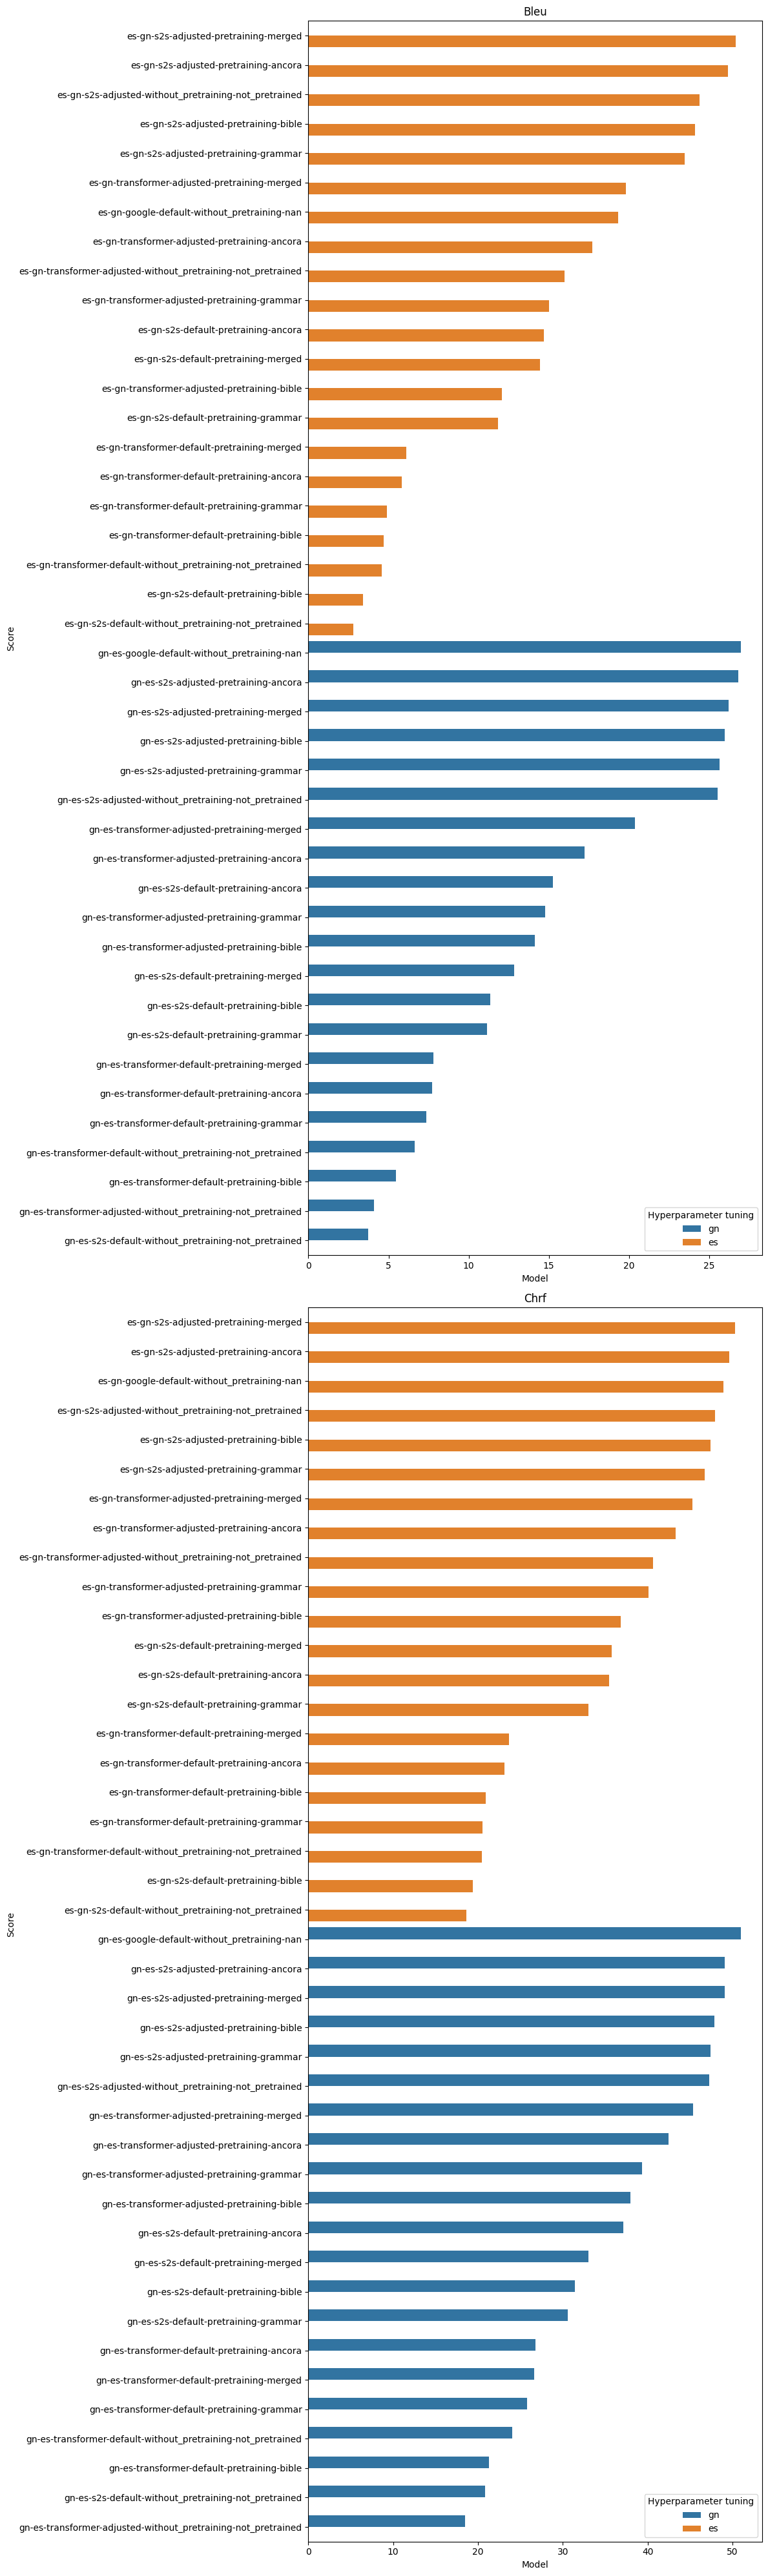

In [13]:
plot_global_scores(df)

### **1.3 Technique Comparison**

The test set involved the following methods:
- Model source: `{ours, google}`
- Model architectures: `{seq2seq, transformers}`
- Pretraining corpus: `{None, grammar, ancora, bible, merged}`
- Hyperparameter tuning: `{adjusted, default}`

In [90]:
df['architecture'].unique()

array(['google', 's2s', 'transformer'], dtype=object)

In [113]:
def plot_technique_comparison(technique: str,
                              save_path: str=None):
    _, ax = plt.subplots(figsize=(15, 6), ncols=2)

    df_ = df.copy()

    capitalize_first_letter = lambda x: x[0].upper() + x[1:]
    column_mapping = {'sacrebleu_corpus_bleu': 'BLEU', 
                      'sacrebleu_corpus_chrf': 'Chrf',
                      'pretraining_corpus': 'Corpus de preentrenamiento',
                      'source': 'Lenguaje de origen',
                      'target': 'Lenguaje de destino',}
    pretraining_mapping = {'pretraining': 'Preentrenado', 
                            'without_pretraining': 'Sin preentrenar'}
    hyperparameter_mapping = {'adjusted': 'Ajustado', 
                              'default': 'default'}
    corpus_mapping = {'grammar': 'Gramática', 
                        'ancora': 'Ancora', 
                        'bible': 'Biblia', 
                        'merged': 'Todo',
                        'not_pretrained': 'Sin preentrenar'}
                           

    df_['pretraining_option'] = df_['pretraining_option'].apply(lambda x: pretraining_mapping[x])
    df_['hyperparameter_tuning_option'] = df_['hyperparameter_tuning_option'].apply(lambda x: hyperparameter_mapping[x])
    df_['architecture'] = df_['architecture'].apply(capitalize_first_letter)
    df_['pretraining_corpus'] = df_['pretraining_corpus'].apply(lambda x: corpus_mapping[x] if x in corpus_mapping else 'Sin preentrenar')
    df_ = df_.rename(column_mapping, axis=1)
    technique = column_mapping[technique] if technique in column_mapping else technique
    source_column = column_mapping.get('source', 'source')
    target_column = column_mapping.get('target', 'target')
    
    # Change hue names position to top right
    sns.boxplot(x=source_column, y='BLEU', 
                    hue=technique,
                    data=df_[df_['architecture'] != 'Google'],
                    ax=ax[0])
    ax[0].legend(loc='upper right')

    
    sns.boxplot(x=source_column, y='Chrf', 
                    hue=technique,
                    data=df_[df_['architecture'] != 'Google'],
                    ax=ax[1])
    ax[1].legend(loc='upper right')

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
        
    plt.show()


#### **1.3.1. Architecture Comparison**

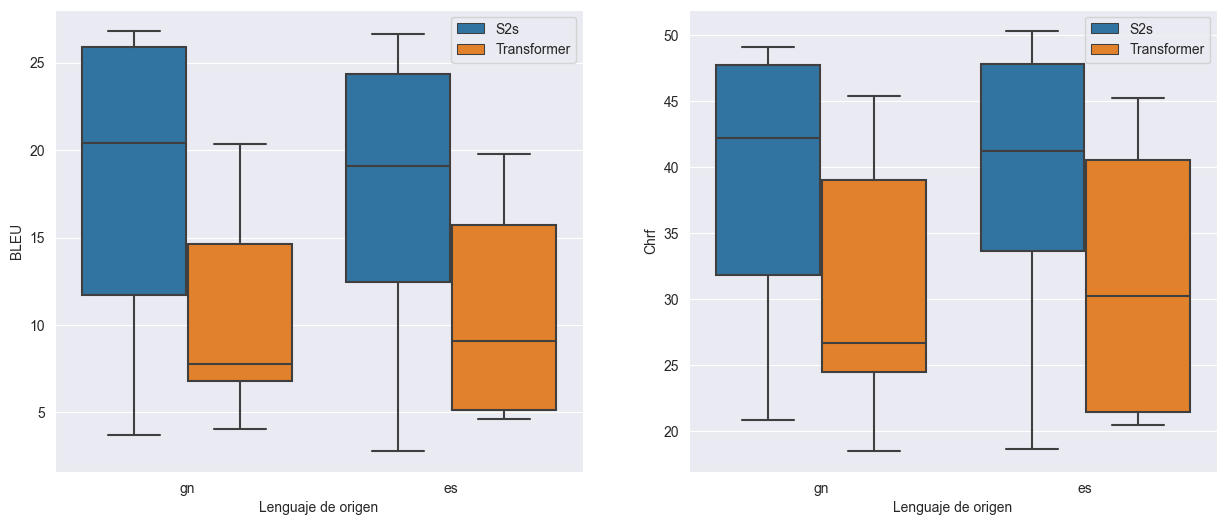

In [107]:
plot_technique_comparison(technique='architecture')

#### **1.3.2. Hyperparameter tuning Comparison**

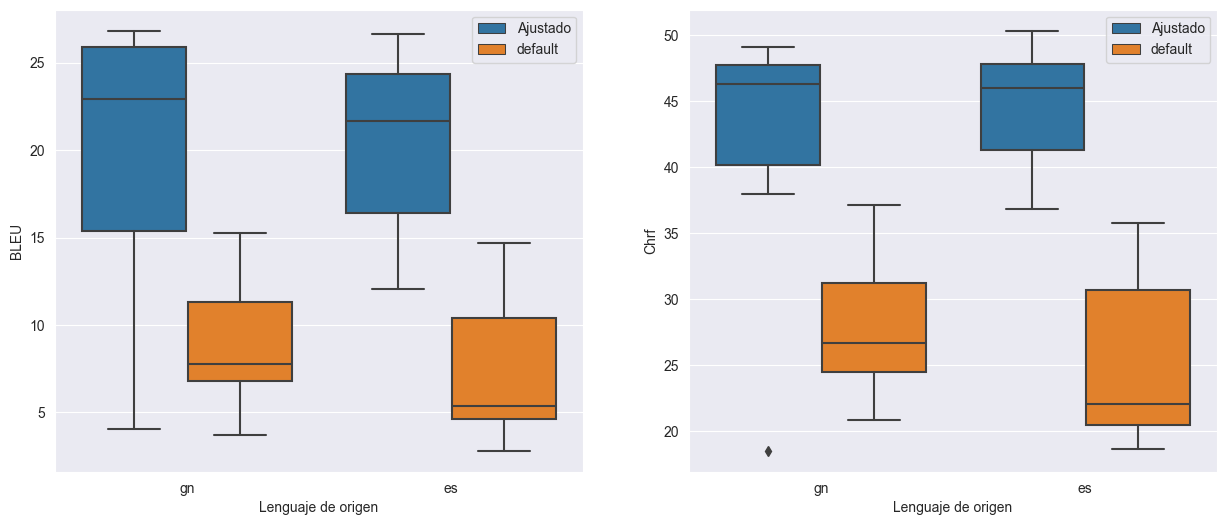

In [108]:
plot_technique_comparison(technique='hyperparameter_tuning_option')

#### **1.3.3. Hyperparameter tuning Comparison**

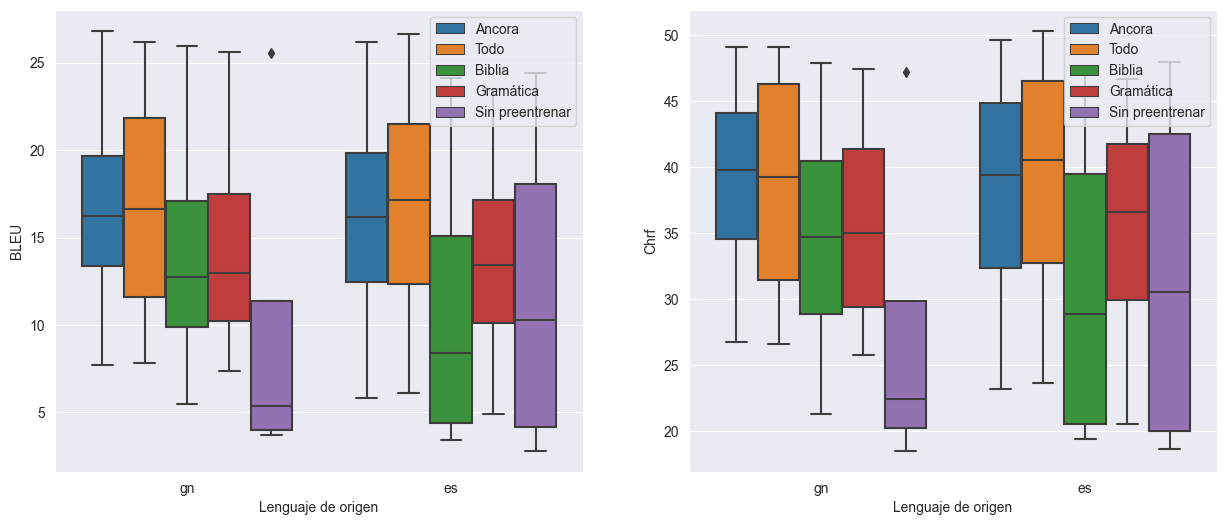

In [114]:
plot_technique_comparison(technique='pretraining_corpus',
                          save_path=os.path.join(RESULTS_DIR, 
                                                 'final_document', 
                                                 'level5_test_set_pretraining_corpus.png'))

## **2. Subset Metrics**

In [8]:
def create_bleu_scores_df(references, translated, bleu_score_types):
    bleu_scores_df = {'reference': [], 
                      'translation': [], 
                      'metric': [], 
                      'score': []}

    for reference, translation in zip(references, translated):
        for bleu_score_type in bleu_score_types:
            bleu_score = metrics.calculate_sacrebleu_sentence(reference, 
                                                translation, 
                                                metric=bleu_score_type)
            bleu_scores_df['reference'].append(reference)
            bleu_scores_df['translation'].append(translation)
            bleu_scores_df['metric'].append(bleu_score_type)
            bleu_scores_df['score'].append(bleu_score)

    return pd.DataFrame(bleu_scores_df)

In [9]:
def get_file_lines(filepath: str, ensure_length=None):
    lines = []
    with open(str(filepath), 'r', encoding='utf-8') as f:
        lines = f.readlines()

    lines = [line[:-1] if line.endswith('\n') else line for line in lines]

    if ensure_length is not None and len(lines) == ensure_length - 1:
        lines = lines + ['']

    return lines

In [10]:
test_gn_filelines = get_file_lines(real_test_set_template.format(trg='gn'))
test_es_filelines = get_file_lines(real_test_set_template.format(trg='es'))
test_length = len(test_gn_filelines)
df['filelines'] = df.apply(lambda row: \
                              get_file_lines(row['filepath'], ensure_length=test_length) if not pd.isna(row['filepath']) else \
                              get_file_lines(GOOGLE_TEST_GN_ES) if row['architecture'] == 'google' and row['source'] == 'gn' else \
                              get_file_lines(GOOGLE_TEST_ES_GN) if row['architecture'] == 'google' and row['source'] == 'es' else \
                              None, 
                           axis=1)

In [11]:
jojajovai_df = pd.read_csv(JOJAJOVAI_DIR)
jojajovai_test_df = jojajovai_df[jojajovai_df['split'] == 'test']
jojajovai_test_df.head()

split source                                                 gn  \
25521  test    abc                                Ko'ágã Cartes turno   
25522  test    abc  Movilización ciudadana oñembyaty ko'ã tendáre ...   
25523  test    abc  Ko'ã manifestante omoî iñakãre ome'ê Yasyretã ...   
25524  test    abc  Tavaygua ko'ã ary oñembyatýva calle España ha ...   
25525  test    abc  Ojehecha despliegue policial ohapejokóva manif...   

                                                      es  \
25521                        Ahora es el turno de Cartes   
25522  La movilización ciudadana se concentra hoy en ...   
25523  Los manifestantes lo responsabilizan de entreg...   
25524  Los ciudadanos de todas las edades se congrega...   
25525  Un importante despliegue policial impidió que ...   

                                               tokens_gn  \
25521                                Ko'ágã Cartes turno   
25522  Movilización ciudadana oñembyaty ko'ã tendáre ...   
25523  Ko'ã manifestante omoî iñakãre ome'ê Yasyretã ...   
25524  Tavaygua ko'ã ary oñembyatýva calle España ha ...   
25525  Ojehecha despliegue policial ohapejokóva manif...   

                                               tokens_es  
25521                        Ahora es el turno de Cartes  
25522  La movilización ciudadana se concentra hoy en ...  
25523  Los manifestantes lo responsabilizan de entreg...  
25524  Los ciudadanos de todas las edades se congrega...  
25525  Un importante despliegue policial impidió que ...

In [12]:
last_source_indices = jojajovai_test_df.groupby(['source']).last()['es'].tolist()
last_source_indices = [test_es_filelines.index(line) for line in last_source_indices]
source_names = jojajovai_test_df['source'].unique().tolist()
source_names

['abc',
 'anlp',
 'blogs',
 'hackaton',
 'libro_gn',
 'libro_td',
 'seminario',
 'spl']

### **2.1 By Corpus Subset**

#### **2.1.1. Subset Length**

One of the main purposes of using pretraining with a grammar was to test whether
using data augmentation for small sentence pairs would enhance translation
quality significantly.

In [81]:
def extract_subset_statistics(source_indices: list[int],
                              last_source_indices: list[int],
                              source_names: list[str],
                              test_gn_filelines: list[str]=test_gn_filelines,
                              test_es_filelines: list[str]=test_es_filelines,
                              plot=True):
    if plot:
        fig, ax = plt.subplots(ncols=len(last_source_indices) // 2, 
                               nrows=2, 
                               figsize=(4*len(last_source_indices), 12))

    current_statistics = collections.defaultdict(list)
    for (start_idx, end_idx), dataset_source in zip(zip(source_indices, 
                                                        last_source_indices),
                                                        source_names):
        subset_gn = test_gn_filelines[start_idx:end_idx+1]
        subset_es = test_es_filelines[start_idx:end_idx+1]
        tokenized_gn = [line.split() for line in subset_gn]
        tokenized_es = [line.split() for line in subset_es]
        tokenized_len_gn = [len(tokens) for tokens in tokenized_gn]
        tokenized_len_es = [len(tokens) for tokens in tokenized_es]

        current_statistics['source'].append(dataset_source)
        current_statistics['source_length'].append(len(subset_gn))
        current_statistics['target_length'].append(len(subset_es))
        current_statistics['source_word_length_median'].append(statistics.median(tokenized_len_gn))
        current_statistics['target_word_length_median'].append(statistics.median(tokenized_len_es))
        current_statistics['source_word_length_mean'].append(statistics.mean(tokenized_len_gn))
        current_statistics['target_word_length_mean'].append(statistics.mean(tokenized_len_es))
        current_statistics['source_word_length_std'].append(statistics.stdev(tokenized_len_gn))
        current_statistics['target_word_length_std'].append(statistics.stdev(tokenized_len_es))

        if plot:
            plot_idx = source_indices.index(start_idx)
            current_ax = ax[plot_idx % 2, plot_idx // 2]
            current_ax.set_title(f'{dataset_source}')
            sns.histplot(tokenized_len_gn, ax=current_ax, color='red', label='source')
            sns.histplot(tokenized_len_es, ax=current_ax, color='blue', label='target')
            current_ax.legend()

    return pd.DataFrame(current_statistics)

In [82]:
def extract_subset_scores(df: pd.DataFrame,
                          source_indices: list[int], 
                          last_source_indices: list[int], 
                          source_names: list[str],
                          score_types: list[str]=score_types,
                          test_gn_filelines: list[str]=test_gn_filelines,
                          test_es_filelines: list[str]=test_es_filelines):
    for metric in score_types:
        for (start_idx, end_idx), dataset_source in zip(zip(source_indices, 
                                                            last_source_indices),
                                                        source_names):
            current_scores = []
            for idx, current_rows in df.iterrows():
                current_filelines = current_rows['filelines']
                test_filelines = test_gn_filelines if current_rows['target'] == 'gn' else test_es_filelines
                current_reference_split = test_filelines[start_idx:end_idx+1]
                current_translation_split = current_filelines[start_idx:end_idx+1]

                if len(current_reference_split) != len(current_translation_split):
                    print(f'WARNING: reference length: {len(current_reference_split)} != current length: {len(current_translation_split)}')
                    current_scores.append(None)
                    continue

                source_score_column = f'{metric}-{dataset_source}'
                current_score = metrics.calculate_metric(current_reference_split, 
                                                        current_translation_split, 
                                                        metric)
                current_scores.append(current_score)
                print(f'{source_score_column}: {current_score}')
            df[source_score_column] = current_scores
    return df

sacrebleu_corpus_bleu-abc: 30.811133853242815
sacrebleu_corpus_bleu-abc: 30.811133853242815
sacrebleu_corpus_bleu-abc: 30.834268733945855
sacrebleu_corpus_bleu-abc: 30.056239358669664
sacrebleu_corpus_bleu-abc: 28.74397732131535
sacrebleu_corpus_bleu-abc: 29.099799077048406
sacrebleu_corpus_bleu-abc: 28.393501462514973
sacrebleu_corpus_bleu-abc: 22.72166108481143
sacrebleu_corpus_bleu-abc: 18.53130536522373
sacrebleu_corpus_bleu-abc: 17.12440691784945
sacrebleu_corpus_bleu-abc: 15.025675562699215
sacrebleu_corpus_bleu-abc: 14.202333473364195
sacrebleu_corpus_bleu-abc: 14.018518473928323
sacrebleu_corpus_bleu-abc: 12.148749798711334
sacrebleu_corpus_bleu-abc: 11.822015637828668
sacrebleu_corpus_bleu-abc: 7.355462564592504
sacrebleu_corpus_bleu-abc: 7.200525157527486
sacrebleu_corpus_bleu-abc: 6.73839357194139
sacrebleu_corpus_bleu-abc: 6.0290984553396045
sacrebleu_corpus_bleu-abc: 4.622654507202785
sacrebleu_corpus_bleu-abc: 2.7268462703246508
sacrebleu_corpus_bleu-abc: 2.10441593911128

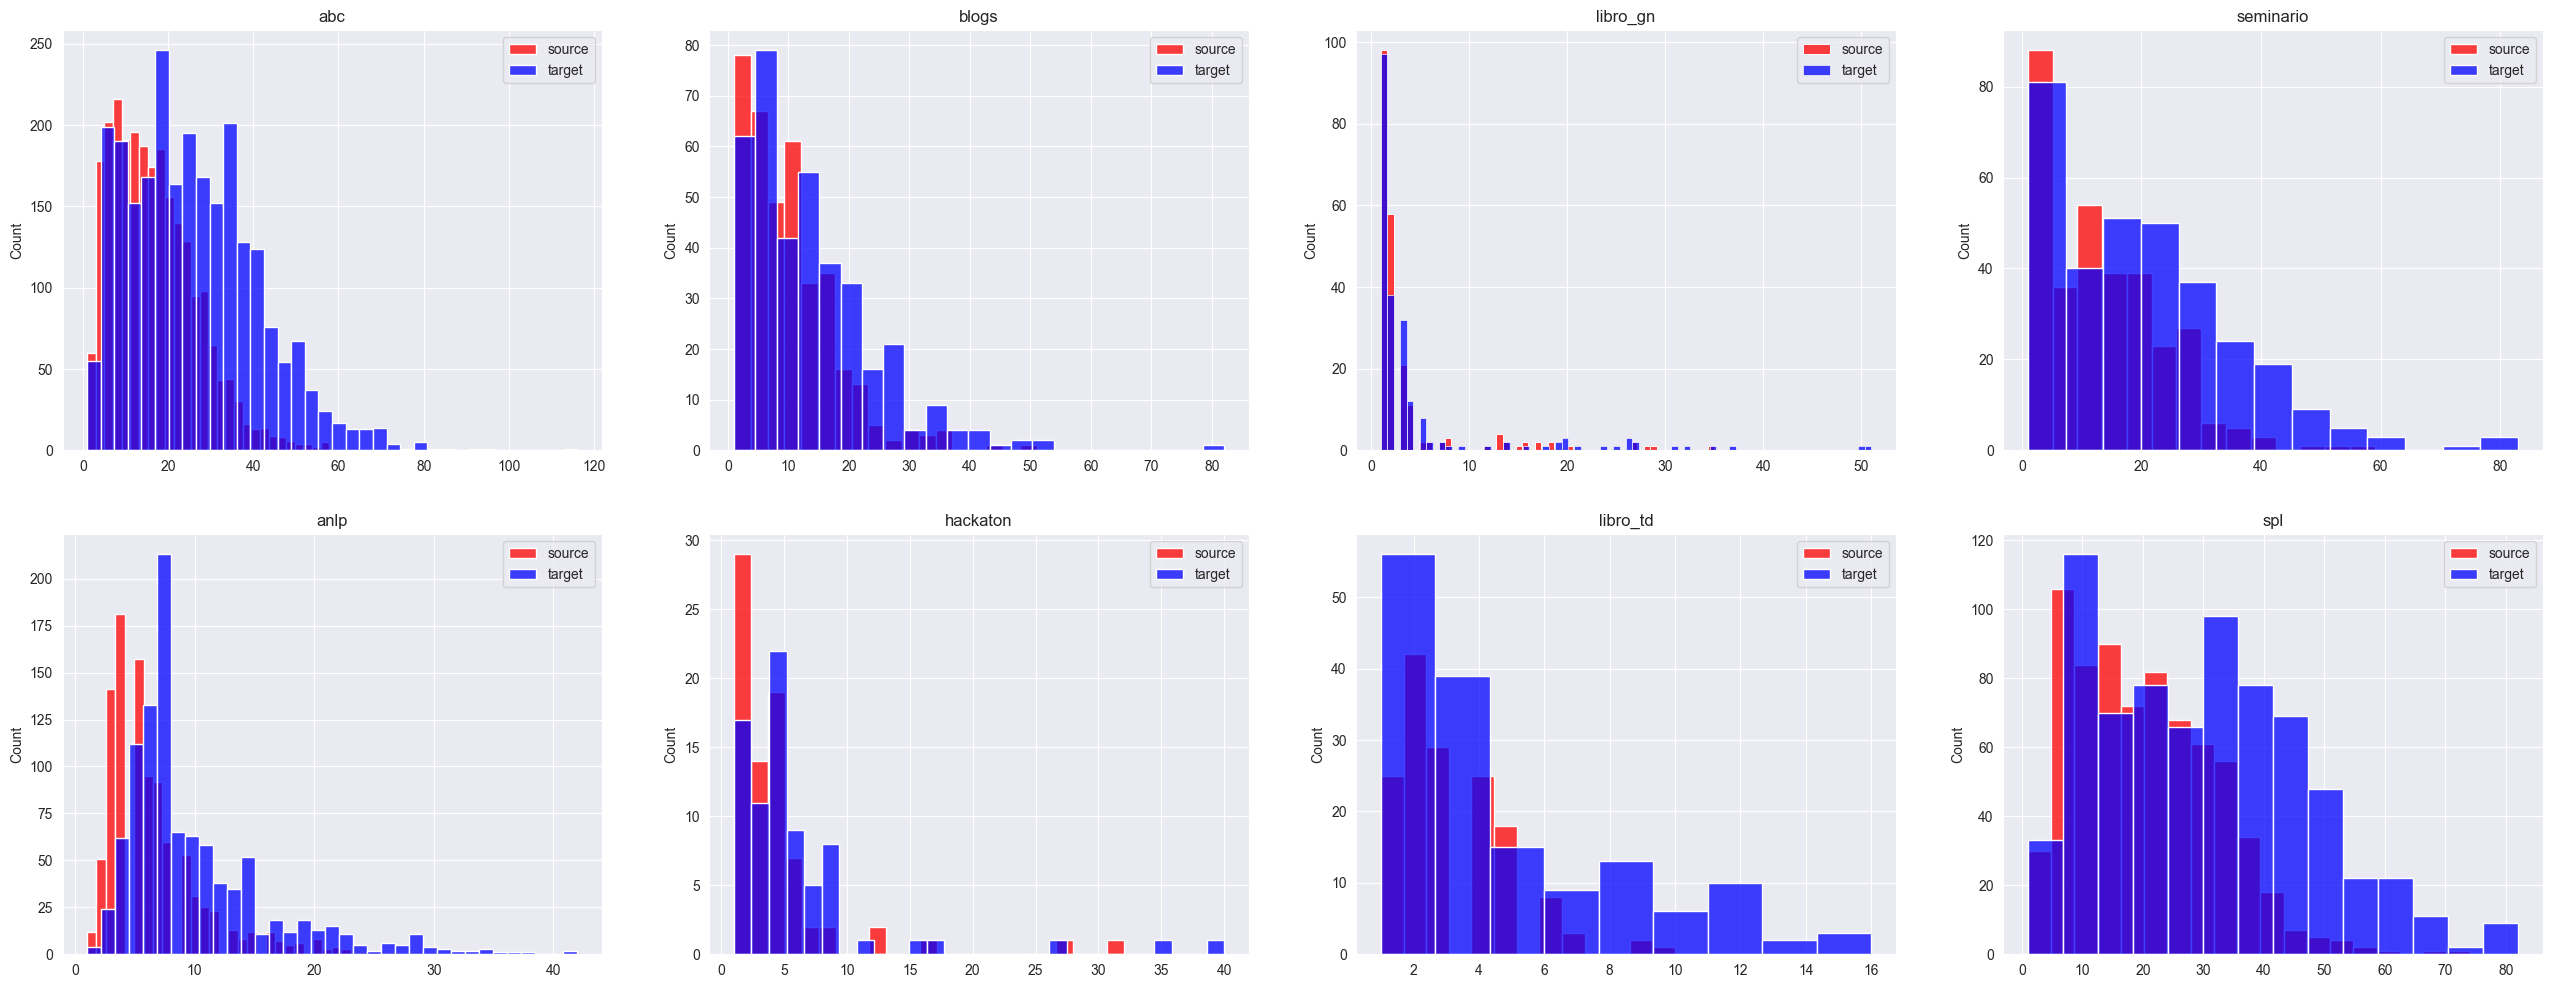

In [83]:
source_indices = [0] + last_source_indices

if not CACHE or not exists_test_set_csv:
    df = extract_subset_scores(df, 
                               source_indices, 
                               last_source_indices, 
                               source_names)

subset_statistics_df = extract_subset_statistics(source_indices, 
                                                 last_source_indices, 
                                                 source_names)

In [84]:
subset_statistics_df.sort_values(by=['target_word_length_median'])

source  source_length  target_length  source_word_length_median  \
4   libro_gn            217            217                        2.0   
5   libro_td            153            153                        3.0   
3   hackaton             78             78                        3.0   
1       anlp           1005           1005                        5.0   
2      blogs            372            372                        9.0   
6  seminario            323            323                       12.0   
0        abc           2472           2472                       16.0   
7        spl            722            722                       20.0   

   target_word_length_median  source_word_length_mean  \
4                        2.0                 3.483871   
5                        3.0                 3.156863   
3                        4.0                 4.487179   
1                        8.0                 6.477612   
2                       12.0                10.190860   
6                       18.0                13.619195   
0                       25.0                17.051375   
7                       29.0                20.411357   

   target_word_length_mean  source_word_length_std  target_word_length_std  
4                 4.654378                5.424649                8.161869  
5                 4.633987                1.770064                3.608746  
3                 5.897436                4.922104                6.427598  
1                10.043781                4.109646                6.256317  
2                13.908602                7.647110               10.558640  
6                20.331269               10.092455               15.692855  
0                26.034385                9.881255               15.187857  
7                29.826870               11.658860               17.075234

**Observation:** The corpus with the lowest word length are:
- libro_gn
- libro_td
- hackaton

#### **2.1.2 Subset Scores**

In [85]:
df = df.sort_index(axis=1).sort_values(by=['source', 'sacrebleu_corpus_bleu'], ascending=False)
df.drop(labels=['filelines'], axis=1).to_csv(TEST_SET_CSV_FILEPATH, index=False)
light_weight_df = df.drop(labels=['filelines', 'filepath'], axis=1)
light_weight_df

architecture hyperparameter_tuning_option  \
0        google                      default   
0        google                      default   
21          s2s                     adjusted   
23          s2s                     adjusted   
22          s2s                     adjusted   
20          s2s                     adjusted   
28          s2s                     adjusted   
3   transformer                     adjusted   
1   transformer                     adjusted   
25          s2s                      default   
0   transformer                     adjusted   
2   transformer                     adjusted   
27          s2s                      default   
26          s2s                      default   
24          s2s                      default   
7   transformer                      default   
5   transformer                      default   
4   transformer                      default   
9   transformer                      default   
6   transformer                      default   
8   transformer                     adjusted   
29          s2s                      default   
33          s2s                     adjusted   
31          s2s                     adjusted   
38          s2s                     adjusted   
32          s2s                     adjusted   
30          s2s                     adjusted   
13  transformer                     adjusted   
1        google                      default   
1        google                      default   
11  transformer                     adjusted   
18  transformer                     adjusted   
10  transformer                     adjusted   
35          s2s                      default   
37          s2s                      default   
12  transformer                     adjusted   
34          s2s                      default   
17  transformer                      default   
15  transformer                      default   
14  transformer                      default   
16  transformer                      default   
19  transformer                      default   
36          s2s                      default   
39          s2s                      default   

                                             model_id pretraining_corpus  \
0        gn-es-google-default-without_pretraining-nan                NaN   
0        gn-es-google-default-without_pretraining-nan                NaN   
21              gn-es-s2s-adjusted-pretraining-ancora             ancora   
23              gn-es-s2s-adjusted-pretraining-merged             merged   
22               gn-es-s2s-adjusted-pretraining-bible              bible   
20             gn-es-s2s-adjusted-pretraining-grammar            grammar   
28  gn-es-s2s-adjusted-without_pretraining-not_pre...     not_pretrained   
3       gn-es-transformer-adjusted-pretraining-merged             merged   
1       gn-es-transformer-adjusted-pretraining-ancora             ancora   
25               gn-es-s2s-default-pretraining-ancora             ancora   
0      gn-es-transformer-adjusted-pretraining-grammar            grammar   
2        gn-es-transformer-adjusted-pretraining-bible              bible   
27               gn-es-s2s-default-pretraining-merged             merged   
26                gn-es-s2s-default-pretraining-bible              bible   
24              gn-es-s2s-default-pretraining-grammar            grammar   
7        gn-es-transformer-default-pretraining-merged             merged   
5        gn-es-transformer-default-pretraining-ancora             ancora   
4       gn-es-transformer-default-pretraining-grammar            grammar   
9   gn-es-transformer-default-without_pretraining-...     not_pretrained   
6         gn-es-transformer-default-pretraining-bible              bible   
8   gn-es-transformer-adjusted-without_pretraining...     not_pretrained   
29  gn-es-s2s-default-without_pretraining-not_pret...     not_pretrained   
33              es-gn-s2s-adjusted-pretraining-merged             merged   
31              es

In [86]:
identifier_columns = ['source', 'target', 'architecture', 'hyperparameter_tuning_option', 'pretraining_corpus', 'pretraining_option']

In [87]:
def extract_metric_from_subset(df: pd.DataFrame,
                               subset: str, 
                               metrics: list[str], 
                               identifier_columns=identifier_columns, 
                               sort=True):
    metric_columns = [f'{metric}-{subset}' for metric in metrics]
    metric_columns = [[metrics[i], metric_columns[i]] for i in range(len(metrics))]
    metric_columns = sum(metric_columns, [])
    current_df = df[identifier_columns + metric_columns]

    if sort:
        current_df = current_df.sort_values(['source', metric_columns[1]], ascending=False)
        
    return current_df

In [143]:
def create_pretraining_pairs_df(pair_rows: list[pd.Series], subset: str):
    pair_data = []
    for grammar_row, no_pretraining_row in pair_rows:
        for metric in score_types:
            metric = metric + '-' + subset
            grammar_score = grammar_row[metric]
            no_pretraining_score = no_pretraining_row[metric]
            improvement = grammar_score - no_pretraining_score
            pair_data.append({
                'source': grammar_row['source'],
                'target': grammar_row['target'],
                'architecture': grammar_row['architecture'],
                'hyperparameter_tuning_option': grammar_row['hyperparameter_tuning_option'],
                'metric': metric,
                'improvement': improvement
            })
    return pair_data
        

def match_pretraining_enhancement(pretraining_corpus: str, subset: str):
    grammar_df = light_weight_df[(light_weight_df['pretraining_corpus']==pretraining_corpus) | 
                                (light_weight_df['pretraining_option']=='without_pretraining')]
    grammar_df['model_id'] = grammar_df['model_id'].cat.remove_unused_categories()

    pair_rows = []
    for _, grammar_row in grammar_df.iterrows():
        if grammar_row['pretraining_corpus'] != pretraining_corpus:
            continue

        for _, no_pretraining_row in grammar_df.iterrows():
            if no_pretraining_row['pretraining_corpus'] != 'not_pretrained':
                continue

            if grammar_row['source'] != no_pretraining_row['source']:
                continue

            if grammar_row['architecture'] != no_pretraining_row['architecture']:
                continue

            if grammar_row['hyperparameter_tuning_option'] != no_pretraining_row['hyperparameter_tuning_option']:
                continue

            pair_rows.append((grammar_row, no_pretraining_row))

    pair_data = create_pretraining_pairs_df(pair_rows, subset)
    pair_df = pd.DataFrame(pair_data)
    pair_df['model_id'] = pair_df['source'] + '-' + pair_df['target'] + '-' + pair_df['architecture'] + '-' + pair_df['hyperparameter_tuning_option']

    return pair_df

def get_best_subset_rows(df: pd.DataFrame, subcorpus: str, n=6):
    return df.groupby('source').apply(lambda x: x.sort_values([f'sacrebleu_corpus_chrf-{subcorpus}'], ascending=False)).reset_index(drop=True).groupby('source').head(n).drop(score_types, axis=1)
    

##### **2.1.2.1. ABC**

In [144]:
subcorpus = 'abc'

In [145]:
current_df = extract_metric_from_subset(light_weight_df, subcorpus, score_types)
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
21     gn     es          s2s                     adjusted             ancora   
0      gn     es       google                      default                NaN   
0      gn     es       google                      default                NaN   
23     gn     es          s2s                     adjusted             merged   
20     gn     es          s2s                     adjusted            grammar   
22     gn     es          s2s                     adjusted              bible   
28     gn     es          s2s                     adjusted     not_pretrained   
3      gn     es  transformer                     adjusted             merged   
1      gn     es  transformer                     adjusted             ancora   
25     gn     es          s2s                      default             ancora   
0      gn     es  transformer                     adjusted            grammar   
2      gn     es  transformer                     adjusted              bible   
27     gn     es          s2s                      default             merged   
26     gn     es          s2s                      default              bible   
24     gn     es          s2s                      default            grammar   
7      gn     es  transformer                      default             merged   
5      gn     es  transformer                      default             ancora   
4      gn     es  transformer                      default            grammar   
9      gn     es  transformer                      default     not_pretrained   
6      gn     es  transformer                      default              bible   
8      gn     es  transformer                     adjusted     not_pretrained   
29     gn     es          s2s                      default     not_pretrained   
33     es     gn          s2s                     adjusted             merged   
31     es     gn          s2s                     adjusted             ancora   
38     es     gn          s2s                     adjusted     not_pretrained   
32     es     gn          s2s                     adjusted              bible   
30     es     gn          s2s                     adjusted            grammar   
1      es     gn       google                      default                NaN   
1      es     gn       google                      default                NaN   
13     es     gn  transformer                     adjusted             merged   
11     es     gn  transformer                     adjusted             ancora   
35     es     gn          s2s                      default             ancora   
18     es     gn  transformer                     adjusted     not_pretrained   
10     es     gn  transformer                     adjusted            grammar   
37     es     gn          s2s                      default             merged   
34     es     gn          s2s                      default            grammar   
12     es     gn  transformer                     adjusted              bible   
17     es     gn  transformer                      default             merged   
15     es     gn  transformer                      default             ancora   
14     es     gn  transformer                      default            grammar   
19     es     gn  transformer                      default     not_pretrained   
16     es     gn  transformer                      default              bible   
36     es     gn          s2s                      default              bible   
39     es     gn          s2s                      default     not_pretrained   

     pretraining_option  sacrebleu_corpus_bleu  sacrebleu_corpus_bleu-abc  \
21          pretraining               26.83030                  30.834269   
0   without_pretraining               26.96010                  30.811134   
0   without_pretraining               26.96010                  30.811134   
23          pretraining               26.20430   

In [146]:
get_best_subset_rows(current_df, subcorpus)

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      es     gn          s2s                     adjusted             merged   
1      es     gn          s2s                     adjusted             ancora   
2      es     gn       google                      default                NaN   
3      es     gn       google                      default                NaN   
4      es     gn          s2s                     adjusted     not_pretrained   
5      es     gn          s2s                     adjusted              bible   
22     gn     es       google                      default                NaN   
23     gn     es       google                      default                NaN   
24     gn     es          s2s                     adjusted             ancora   
25     gn     es          s2s                     adjusted             merged   
26     gn     es          s2s                     adjusted            grammar   
27     gn     es          s2s                     adjusted              bible   

     pretraining_option  sacrebleu_corpus_bleu-abc  sacrebleu_corpus_chrf-abc  \
0           pretraining                  31.454903                  58.763727   
1           pretraining                  31.157260                  58.335601   
2   without_pretraining                  23.555040                  56.611114   
3   without_pretraining                  23.555040                  56.611114   
4   without_pretraining                  27.883832                  55.142737   
5           pretraining                  27.577661                  54.445066   
22  without_pretraining                  30.811134                  56.730363   
23  without_pretraining                  30.811134                  56.730363   
24          pretraining                  30.834269                  56.309795   
25          pretraining                  30.056239                  56.171679   
26          pretraining                  29.099799                  54.252993   
27          pretraining                  28.743977                  53.896606   

    sacrebleu_corpus_ter-abc  
0                  59.075704  
1                  60.707931  
2                  70.902232  
3                  70.902232  
4                  63.464686  
5                  65.697136  
22                 56.609227  
23                 56.609227  
24                 57.112668  
25                 57.449850  
26                 60.938204  
27                 61.059403

##### **2.1.2.2. ANLP**

In [147]:
subcorpus = 'anlp'

In [148]:
current_df = extract_metric_from_subset(light_weight_df, subcorpus, score_types)
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      gn     es       google                      default                NaN   
0      gn     es       google                      default                NaN   
23     gn     es          s2s                     adjusted             merged   
21     gn     es          s2s                     adjusted             ancora   
3      gn     es  transformer                     adjusted             merged   
20     gn     es          s2s                     adjusted            grammar   
22     gn     es          s2s                     adjusted              bible   
28     gn     es          s2s                     adjusted     not_pretrained   
25     gn     es          s2s                      default             ancora   
1      gn     es  transformer                     adjusted             ancora   
0      gn     es  transformer                     adjusted            grammar   
2      gn     es  transformer                     adjusted              bible   
27     gn     es          s2s                      default             merged   
7      gn     es  transformer                      default             merged   
24     gn     es          s2s                      default            grammar   
4      gn     es  transformer                      default            grammar   
26     gn     es          s2s                      default              bible   
5      gn     es  transformer                      default             ancora   
6      gn     es  transformer                      default              bible   
9      gn     es  transformer                      default     not_pretrained   
29     gn     es          s2s                      default     not_pretrained   
8      gn     es  transformer                     adjusted     not_pretrained   
1      es     gn       google                      default                NaN   
1      es     gn       google                      default                NaN   
33     es     gn          s2s                     adjusted             merged   
31     es     gn          s2s                     adjusted             ancora   
32     es     gn          s2s                     adjusted              bible   
13     es     gn  transformer                     adjusted             merged   
30     es     gn          s2s                     adjusted            grammar   
38     es     gn          s2s                     adjusted     not_pretrained   
11     es     gn  transformer                     adjusted             ancora   
10     es     gn  transformer                     adjusted            grammar   
37     es     gn          s2s                      default             merged   
35     es     gn          s2s                      default             ancora   
18     es     gn  transformer                     adjusted     not_pretrained   
12     es     gn  transformer                     adjusted              bible   
17     es     gn  transformer                      default             merged   
34     es     gn          s2s                      default            grammar   
14     es     gn  transformer                      default            grammar   
15     es     gn  transformer                      default             ancora   
16     es     gn  transformer                      default              bible   
19     es     gn  transformer                      default     not_pretrained   
36     es     gn          s2s                      default              bible   
39     es     gn          s2s                      default     not_pretrained   

     pretraining_option  sacrebleu_corpus_bleu  sacrebleu_corpus_bleu-anlp  \
0   without_pretraining               26.96010                   19.804009   
0   without_pretraining               26.96010                   19.804009   
23          pretraining               26.20430                    4.325033   
21          pretraining               26.8303

In [149]:
get_best_subset_rows(current_df, subcorpus=subcorpus)

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      es     gn       google                      default                NaN   
1      es     gn       google                      default                NaN   
2      es     gn          s2s                     adjusted             merged   
3      es     gn          s2s                     adjusted             ancora   
4      es     gn  transformer                     adjusted             merged   
5      es     gn          s2s                     adjusted              bible   
22     gn     es       google                      default                NaN   
23     gn     es       google                      default                NaN   
24     gn     es          s2s                     adjusted             merged   
25     gn     es  transformer                     adjusted             merged   
26     gn     es          s2s                     adjusted             ancora   
27     gn     es          s2s                     adjusted              bible   

     pretraining_option  sacrebleu_corpus_bleu-anlp  \
0   without_pretraining                    6.007164   
1   without_pretraining                    6.007164   
2           pretraining                    3.013558   
3           pretraining                    2.656482   
4           pretraining                    2.224783   
5           pretraining                    2.385869   
22  without_pretraining                   19.804009   
23  without_pretraining                   19.804009   
24          pretraining                    4.325033   
25          pretraining                    3.179696   
26          pretraining                    4.037449   
27          pretraining                    2.995689   

    sacrebleu_corpus_chrf-anlp  sacrebleu_corpus_ter-anlp  
0                    37.045665                  98.233487  
1                    37.045665                  98.233487  
2                    24.578048                  96.006144  
3                    23.587338                  97.480799  
4                    22.493833                  95.791091  
5                    21.830709                  97.142857  
22                   42.038928                  66.891223  
23                   42.038928                  66.891223  
24                   21.482503                  87.368734  
25                   21.450058                  87.507430  
26                   21.169321                  88.676441  
27                   19.466960                  91.420646

##### **2.1.2.3. blogs**

In [150]:
subcorpus = 'blogs'

In [151]:
current_df = extract_metric_from_subset(light_weight_df, subcorpus, score_types)
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      gn     es       google                      default                NaN   
0      gn     es       google                      default                NaN   
23     gn     es          s2s                     adjusted             merged   
21     gn     es          s2s                     adjusted             ancora   
22     gn     es          s2s                     adjusted              bible   
28     gn     es          s2s                     adjusted     not_pretrained   
20     gn     es          s2s                     adjusted            grammar   
3      gn     es  transformer                     adjusted             merged   
1      gn     es  transformer                     adjusted             ancora   
0      gn     es  transformer                     adjusted            grammar   
25     gn     es          s2s                      default             ancora   
2      gn     es  transformer                     adjusted              bible   
27     gn     es          s2s                      default             merged   
24     gn     es          s2s                      default            grammar   
26     gn     es          s2s                      default              bible   
4      gn     es  transformer                      default            grammar   
5      gn     es  transformer                      default             ancora   
7      gn     es  transformer                      default             merged   
9      gn     es  transformer                      default     not_pretrained   
6      gn     es  transformer                      default              bible   
29     gn     es          s2s                      default     not_pretrained   
8      gn     es  transformer                     adjusted     not_pretrained   
1      es     gn       google                      default                NaN   
1      es     gn       google                      default                NaN   
33     es     gn          s2s                     adjusted             merged   
31     es     gn          s2s                     adjusted             ancora   
30     es     gn          s2s                     adjusted            grammar   
32     es     gn          s2s                     adjusted              bible   
38     es     gn          s2s                     adjusted     not_pretrained   
13     es     gn  transformer                     adjusted             merged   
11     es     gn  transformer                     adjusted             ancora   
10     es     gn  transformer                     adjusted            grammar   
18     es     gn  transformer                     adjusted     not_pretrained   
35     es     gn          s2s                      default             ancora   
37     es     gn          s2s                      default             merged   
12     es     gn  transformer                     adjusted              bible   
34     es     gn          s2s                      default            grammar   
17     es     gn  transformer                      default             merged   
15     es     gn  transformer                      default             ancora   
19     es     gn  transformer                      default     not_pretrained   
16     es     gn  transformer                      default              bible   
14     es     gn  transformer                      default            grammar   
36     es     gn          s2s                      default              bible   
39     es     gn          s2s                      default     not_pretrained   

     pretraining_option  sacrebleu_corpus_bleu  sacrebleu_corpus_bleu-blogs  \
0   without_pretraining               26.96010                    24.445486   
0   without_pretraining               26.96010                    24.445486   
23          pretraining               26.20430                    18.442991   
21          pretraining               26.

In [152]:
get_best_subset_rows(current_df, subcorpus)

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      es     gn       google                      default                NaN   
1      es     gn       google                      default                NaN   
2      es     gn          s2s                     adjusted             merged   
3      es     gn          s2s                     adjusted             ancora   
4      es     gn          s2s                     adjusted     not_pretrained   
5      es     gn          s2s                     adjusted              bible   
22     gn     es       google                      default                NaN   
23     gn     es       google                      default                NaN   
24     gn     es          s2s                     adjusted             merged   
25     gn     es          s2s                     adjusted             ancora   
26     gn     es          s2s                     adjusted              bible   
27     gn     es          s2s                     adjusted     not_pretrained   

     pretraining_option  sacrebleu_corpus_bleu-blogs  \
0   without_pretraining                    16.272132   
1   without_pretraining                    16.272132   
2           pretraining                    16.102236   
3           pretraining                    15.342377   
4   without_pretraining                    14.438278   
5           pretraining                    14.668008   
22  without_pretraining                    24.445486   
23  without_pretraining                    24.445486   
24          pretraining                    18.442991   
25          pretraining                    18.128379   
26          pretraining                    17.220267   
27  without_pretraining                    16.094188   

    sacrebleu_corpus_chrf-blogs  sacrebleu_corpus_ter-blogs  
0                     39.377703                   80.796624  
1                     39.377703                   80.796624  
2                     32.297513                   80.902137  
3                     31.551974                   82.300185  
4                     30.690440                   80.743867  
5                     30.282735                   81.113163  
22                    45.253582                   66.621569  
23                    45.253582                   66.621569  
24                    34.538101                   75.067646  
25                    33.368463                   76.130653  
26                    32.682052                   77.638191  
27                    31.512627                   80.344028

##### **2.1.2.4. Hackaton (Short sentence pairs)**

In [153]:
subcorpus = 'hackaton'

In [154]:
current_df = extract_metric_from_subset(light_weight_df, subcorpus, score_types)
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      gn     es       google                      default                NaN   
0      gn     es       google                      default                NaN   
23     gn     es          s2s                     adjusted             merged   
28     gn     es          s2s                     adjusted     not_pretrained   
20     gn     es          s2s                     adjusted            grammar   
21     gn     es          s2s                     adjusted             ancora   
3      gn     es  transformer                     adjusted             merged   
22     gn     es          s2s                     adjusted              bible   
27     gn     es          s2s                      default             merged   
0      gn     es  transformer                     adjusted            grammar   
1      gn     es  transformer                     adjusted             ancora   
25     gn     es          s2s                      default             ancora   
5      gn     es  transformer                      default             ancora   
4      gn     es  transformer                      default            grammar   
9      gn     es  transformer                      default     not_pretrained   
7      gn     es  transformer                      default             merged   
2      gn     es  transformer                     adjusted              bible   
24     gn     es          s2s                      default            grammar   
26     gn     es          s2s                      default              bible   
6      gn     es  transformer                      default              bible   
29     gn     es          s2s                      default     not_pretrained   
8      gn     es  transformer                     adjusted     not_pretrained   
1      es     gn       google                      default                NaN   
1      es     gn       google                      default                NaN   
33     es     gn          s2s                     adjusted             merged   
38     es     gn          s2s                     adjusted     not_pretrained   
31     es     gn          s2s                     adjusted             ancora   
30     es     gn          s2s                     adjusted            grammar   
34     es     gn          s2s                      default            grammar   
14     es     gn  transformer                      default            grammar   
12     es     gn  transformer                     adjusted              bible   
13     es     gn  transformer                     adjusted             merged   
16     es     gn  transformer                      default              bible   
18     es     gn  transformer                     adjusted     not_pretrained   
10     es     gn  transformer                     adjusted            grammar   
17     es     gn  transformer                      default             merged   
11     es     gn  transformer                     adjusted             ancora   
32     es     gn          s2s                     adjusted              bible   
37     es     gn          s2s                      default             merged   
35     es     gn          s2s                      default             ancora   
39     es     gn          s2s                      default     not_pretrained   
15     es     gn  transformer                      default             ancora   
19     es     gn  transformer                      default     not_pretrained   
36     es     gn          s2s                      default              bible   

     pretraining_option  sacrebleu_corpus_bleu  \
0   without_pretraining               26.96010   
0   without_pretraining               26.96010   
23          pretraining               26.20430   
28  without_pretraining               25.53190   
20          pretraining               25.63350   
21          pretraining               26.83030   
3      

In [155]:
get_best_subset_rows(current_df, subcorpus)

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      es     gn       google                      default                NaN   
1      es     gn       google                      default                NaN   
2      es     gn          s2s                     adjusted             merged   
3      es     gn          s2s                     adjusted             ancora   
4      es     gn          s2s                     adjusted              bible   
5      es     gn          s2s                     adjusted            grammar   
22     gn     es       google                      default                NaN   
23     gn     es       google                      default                NaN   
24     gn     es          s2s                     adjusted             merged   
25     gn     es          s2s                     adjusted            grammar   
26     gn     es          s2s                     adjusted             ancora   
27     gn     es          s2s                     adjusted     not_pretrained   

     pretraining_option  sacrebleu_corpus_bleu-hackaton  \
0   without_pretraining                        5.748512   
1   without_pretraining                        5.748512   
2           pretraining                        5.468400   
3           pretraining                        3.671089   
4           pretraining                        2.367393   
5           pretraining                        3.489030   
22  without_pretraining                       18.444787   
23  without_pretraining                       18.444787   
24          pretraining                       14.690988   
25          pretraining                       11.469580   
26          pretraining                       10.863782   
27  without_pretraining                       12.675077   

    sacrebleu_corpus_chrf-hackaton  sacrebleu_corpus_ter-hackaton  
0                        41.706403                      88.857143  
1                        41.706403                      88.857143  
2                        34.687165                      82.285714  
3                        31.653378                      86.571429  
4                        28.803142                      88.857143  
5                        28.697942                      88.285714  
22                       46.345195                      65.434783  
23                       46.345195                      65.434783  
24                       31.086082                      74.565217  
25                       30.368687                      83.478261  
26                       30.336946                      78.695652  
27                       30.136839                      81.956522

In [156]:
pair_df = match_pretraining_enhancement(pretraining_corpus='grammar', subset='hackaton')
pair_df


source target architecture hyperparameter_tuning_option  \
0      gn     es          s2s                     adjusted   
1      gn     es          s2s                     adjusted   
2      gn     es          s2s                     adjusted   
3      gn     es  transformer                     adjusted   
4      gn     es  transformer                     adjusted   
5      gn     es  transformer                     adjusted   
6      gn     es          s2s                      default   
7      gn     es          s2s                      default   
8      gn     es          s2s                      default   
9      gn     es  transformer                      default   
10     gn     es  transformer                      default   
11     gn     es  transformer                      default   
12     es     gn          s2s                     adjusted   
13     es     gn          s2s                     adjusted   
14     es     gn          s2s                     adjusted   
15     es     gn  transformer                     adjusted   
16     es     gn  transformer                     adjusted   
17     es     gn  transformer                     adjusted   
18     es     gn          s2s                      default   
19     es     gn          s2s                      default   
20     es     gn          s2s                      default   
21     es     gn  transformer                      default   
22     es     gn  transformer                      default   
23     es     gn  transformer                      default   

                            metric  improvement                    model_id  
0   sacrebleu_corpus_bleu-hackaton    -1.205497          gn-es-s2s-adjusted  
1   sacrebleu_corpus_chrf-hackaton     0.231848          gn-es-s2s-adjusted  
2    sacrebleu_corpus_ter-hackaton     1.521739          gn-es-s2s-adjusted  
3   sacrebleu_corpus_bleu-hackaton     6.328313  gn-es-transformer-adjusted  
4   sacrebleu_corpus_chrf-hackaton    13.670621  gn-es-transformer-adjusted  
5    sacrebleu_corpus_ter-hackaton    -9.782609  gn-es-transformer-adjusted  
6   sacrebleu_corpus_bleu-hackaton     1.826391           gn-es-s2s-default  
7   sacrebleu_corpus_chrf-hackaton     1.242237           gn-es-s2s-default  
8    sacrebleu_corpus_ter-hackaton    -6.956522           gn-es-s2s-default  
9   sacrebleu_corpus_bleu-hackaton     0.013076   gn-es-transformer-default  
10  sacrebleu_corpus_chrf-hackaton     2.137138   gn-es-transformer-default  
11   sacrebleu_corpus_ter-hackaton     0.869565   gn-es-transformer-default  
12  sacrebleu_corpus_bleu-hackaton    -0.262846          es-gn-s2s-adjusted  
13  sacrebleu_corpus_chrf-hackaton     1.545776          es-gn-s2s-adjusted  
14   sacrebleu_corpus_ter-hackaton     3.142857          es-gn-s2s-adjusted  
15  sacrebleu_corpus_bleu-hackaton    -0.073274  es-gn-transformer-adjusted  
16  sacrebleu_corpus_chrf-hackaton     2.174289  es-gn-transformer-adjusted  
17   sacrebleu_corpus_ter-hackaton     0.285714  es-gn-transformer-adjusted  
18  sacrebleu_corpus_bleu-hackaton     1.557054           es-gn-s2s-default  
19  sacrebleu_corpus_chrf-hackaton     8.248393           es-gn-s2s-default  
20   sacrebleu_corpus_ter-hackaton    -5.714286           es-gn-s2s-default  
21  sacrebleu_corpus_bleu-hackaton     1.612057   es-gn-transformer-default  
22  sacrebleu_corpus_chrf-hackaton     3.284423   es-gn-transformer-default  
23   sacrebleu_corpus_ter-hackaton    -0.571429   es-gn-transformer-default

In [157]:
pair_df.describe()

improvement
count    24.000000
mean      1.046876
std       4.628481
min      -9.782609
25%      -0.120667
50%       1.381988
75%       2.146425
max      13.670621

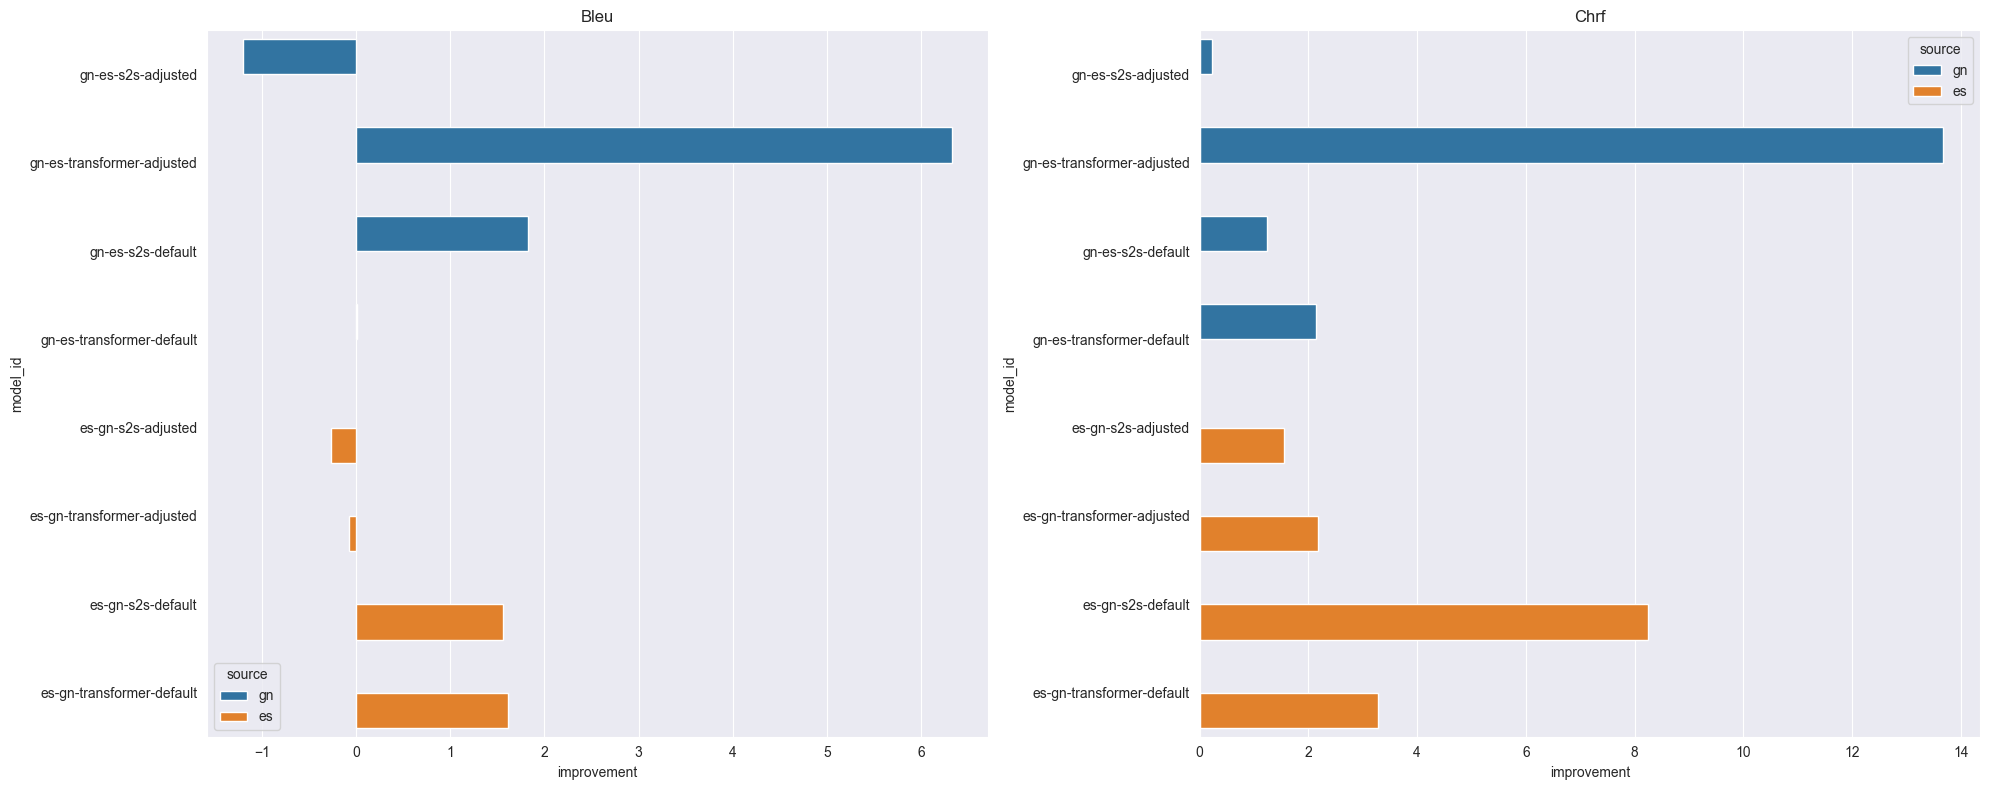

In [158]:
fig, ax = plt.subplots(figsize=(20, 8), ncols=2)
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_bleu-hackaton'], ax=ax[0]);
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_chrf-hackaton'], ax=ax[1]);

ax[0].set_title('Bleu')
ax[1].set_title('Chrf')
plt.tight_layout()

##### **2.1.2.5. libro_gn**

In [159]:
subcorpus = 'libro_gn'

In [160]:
current_df = extract_metric_from_subset(light_weight_df, subcorpus, score_types)
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      gn     es       google                      default                NaN   
0      gn     es       google                      default                NaN   
22     gn     es          s2s                     adjusted              bible   
21     gn     es          s2s                     adjusted             ancora   
28     gn     es          s2s                     adjusted     not_pretrained   
23     gn     es          s2s                     adjusted             merged   
20     gn     es          s2s                     adjusted            grammar   
3      gn     es  transformer                     adjusted             merged   
25     gn     es          s2s                      default             ancora   
0      gn     es  transformer                     adjusted            grammar   
1      gn     es  transformer                     adjusted             ancora   
2      gn     es  transformer                     adjusted              bible   
24     gn     es          s2s                      default            grammar   
27     gn     es          s2s                      default             merged   
7      gn     es  transformer                      default             merged   
9      gn     es  transformer                      default     not_pretrained   
4      gn     es  transformer                      default            grammar   
5      gn     es  transformer                      default             ancora   
26     gn     es          s2s                      default              bible   
6      gn     es  transformer                      default              bible   
29     gn     es          s2s                      default     not_pretrained   
8      gn     es  transformer                     adjusted     not_pretrained   
31     es     gn          s2s                     adjusted             ancora   
38     es     gn          s2s                     adjusted     not_pretrained   
1      es     gn       google                      default                NaN   
1      es     gn       google                      default                NaN   
33     es     gn          s2s                     adjusted             merged   
32     es     gn          s2s                     adjusted              bible   
30     es     gn          s2s                     adjusted            grammar   
13     es     gn  transformer                     adjusted             merged   
37     es     gn          s2s                      default             merged   
35     es     gn          s2s                      default             ancora   
34     es     gn          s2s                      default            grammar   
18     es     gn  transformer                     adjusted     not_pretrained   
11     es     gn  transformer                     adjusted             ancora   
10     es     gn  transformer                     adjusted            grammar   
14     es     gn  transformer                      default            grammar   
19     es     gn  transformer                      default     not_pretrained   
12     es     gn  transformer                     adjusted              bible   
17     es     gn  transformer                      default             merged   
15     es     gn  transformer                      default             ancora   
16     es     gn  transformer                      default              bible   
39     es     gn          s2s                      default     not_pretrained   
36     es     gn          s2s                      default              bible   

     pretraining_option  sacrebleu_corpus_bleu  \
0   without_pretraining               26.96010   
0   without_pretraining               26.96010   
22          pretraining               25.97270   
21          pretraining               26.83030   
28  without_pretraining               25.53190   
23          pretraining               26.20430   
20     

In [161]:
get_best_subset_rows(current_df, subcorpus)

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      es     gn          s2s                     adjusted     not_pretrained   
1      es     gn          s2s                     adjusted             merged   
2      es     gn          s2s                     adjusted              bible   
3      es     gn          s2s                     adjusted             ancora   
4      es     gn       google                      default                NaN   
5      es     gn       google                      default                NaN   
22     gn     es       google                      default                NaN   
23     gn     es       google                      default                NaN   
24     gn     es          s2s                     adjusted             ancora   
25     gn     es          s2s                     adjusted     not_pretrained   
26     gn     es          s2s                     adjusted              bible   
27     gn     es          s2s                     adjusted             merged   

     pretraining_option  sacrebleu_corpus_bleu-libro_gn  \
0   without_pretraining                        8.548726   
1           pretraining                        7.717086   
2           pretraining                        7.595527   
3           pretraining                       10.862935   
4   without_pretraining                        8.302423   
5   without_pretraining                        8.302423   
22  without_pretraining                       11.293379   
23  without_pretraining                       11.293379   
24          pretraining                       10.500771   
25  without_pretraining                        9.804670   
26          pretraining                       10.866241   
27          pretraining                        9.704860   

    sacrebleu_corpus_chrf-libro_gn  sacrebleu_corpus_ter-libro_gn  
0                        30.162211                      84.523810  
1                        30.156378                      85.714286  
2                        28.991835                      87.698413  
3                        28.932207                      86.243386  
4                        28.821167                     101.190476  
5                        28.821167                     101.190476  
22                       31.875341                      95.841584  
23                       31.875341                      95.841584  
24                       30.355659                      83.861386  
25                       30.244107                      87.623762  
26                       30.143020                      87.821782  
27                       28.559419                      82.376238

In [162]:
pair_df = match_pretraining_enhancement(pretraining_corpus='grammar', subset=subcorpus)
pair_df

source target architecture hyperparameter_tuning_option  \
0      gn     es          s2s                     adjusted   
1      gn     es          s2s                     adjusted   
2      gn     es          s2s                     adjusted   
3      gn     es  transformer                     adjusted   
4      gn     es  transformer                     adjusted   
5      gn     es  transformer                     adjusted   
6      gn     es          s2s                      default   
7      gn     es          s2s                      default   
8      gn     es          s2s                      default   
9      gn     es  transformer                      default   
10     gn     es  transformer                      default   
11     gn     es  transformer                      default   
12     es     gn          s2s                     adjusted   
13     es     gn          s2s                     adjusted   
14     es     gn          s2s                     adjusted   
15     es     gn  transformer                     adjusted   
16     es     gn  transformer                     adjusted   
17     es     gn  transformer                     adjusted   
18     es     gn          s2s                      default   
19     es     gn          s2s                      default   
20     es     gn          s2s                      default   
21     es     gn  transformer                      default   
22     es     gn  transformer                      default   
23     es     gn  transformer                      default   

                            metric  improvement                    model_id  
0   sacrebleu_corpus_bleu-libro_gn    -0.779567          gn-es-s2s-adjusted  
1   sacrebleu_corpus_chrf-libro_gn    -3.173115          gn-es-s2s-adjusted  
2    sacrebleu_corpus_ter-libro_gn    -1.584158          gn-es-s2s-adjusted  
3   sacrebleu_corpus_bleu-libro_gn     5.537663  gn-es-transformer-adjusted  
4   sacrebleu_corpus_chrf-libro_gn    14.117468  gn-es-transformer-adjusted  
5    sacrebleu_corpus_ter-libro_gn    -9.405941  gn-es-transformer-adjusted  
6   sacrebleu_corpus_bleu-libro_gn     3.751647           gn-es-s2s-default  
7   sacrebleu_corpus_chrf-libro_gn     1.273249           gn-es-s2s-default  
8    sacrebleu_corpus_ter-libro_gn    -5.445545           gn-es-s2s-default  
9   sacrebleu_corpus_bleu-libro_gn    -0.027446   gn-es-transformer-default  
10  sacrebleu_corpus_chrf-libro_gn    -0.651704   gn-es-transformer-default  
11   sacrebleu_corpus_ter-libro_gn     0.297030   gn-es-transformer-default  
12  sacrebleu_corpus_bleu-libro_gn    -1.659048          es-gn-s2s-adjusted  
13  sacrebleu_corpus_chrf-libro_gn    -2.343251          es-gn-s2s-adjusted  
14   sacrebleu_corpus_ter-libro_gn     3.042328          es-gn-s2s-adjusted  
15  sacrebleu_corpus_bleu-libro_gn    -1.558662  es-gn-transformer-adjusted  
16  sacrebleu_corpus_chrf-libro_gn    -3.699370  es-gn-transformer-adjusted  
17   sacrebleu_corpus_ter-libro_gn     2.910053  es-gn-transformer-adjusted  
18  sacrebleu_corpus_bleu-libro_gn     3.625556           es-gn-s2s-default  
19  sacrebleu_corpus_chrf-libro_gn     2.982211           es-gn-s2s-default  
20   sacrebleu_corpus_ter-libro_gn    -7.142857           es-gn-s2s-default  
21  sacrebleu_corpus_bleu-libro_gn     0.377716   es-gn-transformer-default  
22  sacrebleu_corpus_chrf-libro_gn     0.927054   es-gn-transformer-default  
23   sacrebleu_corpus_ter-libro_gn    -2.645503   es-gn-transformer-default

In [163]:
pair_df.describe()

improvement
count    24.000000
mean     -0.053091
std       4.665153
min      -9.405941
25%      -2.418814
50%      -0.339575
75%       2.928092
max      14.117468

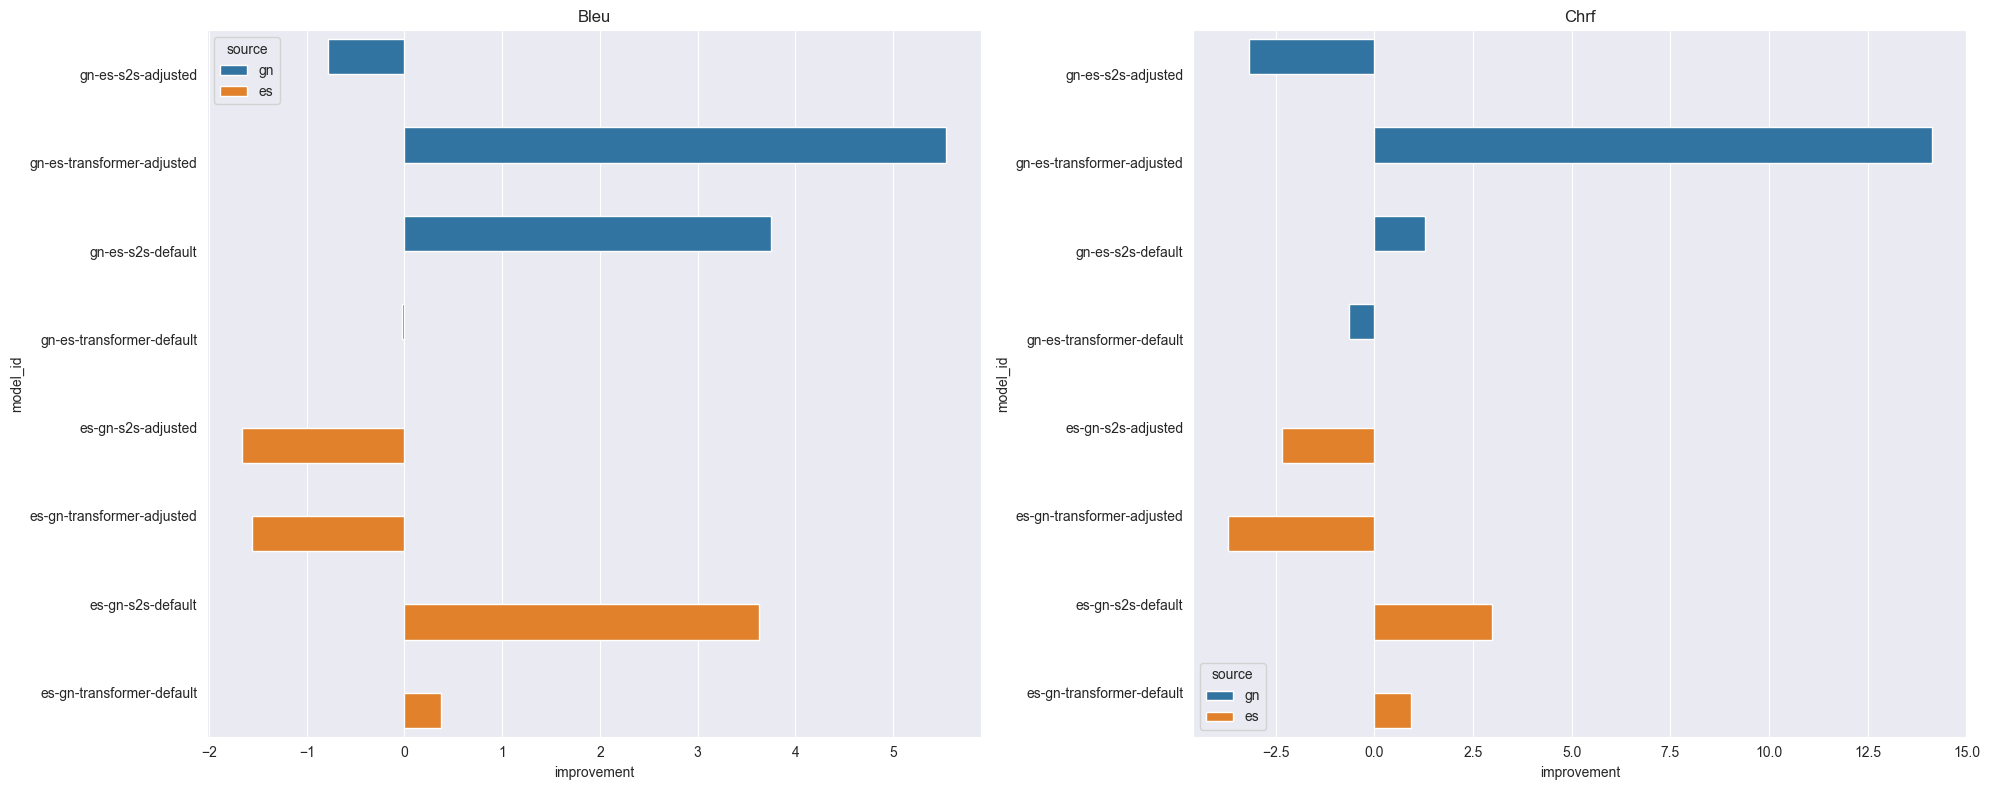

In [164]:
fig, ax = plt.subplots(figsize=(20, 8), ncols=2)
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_bleu-libro_gn'], ax=ax[0]);
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_chrf-libro_gn'], ax=ax[1]);

ax[0].set_title('Bleu')
ax[1].set_title('Chrf')
plt.tight_layout()

##### **2.1.2.6. libro_td**

In [165]:
subcorpus = 'libro_td'

In [166]:
current_df = extract_metric_from_subset(light_weight_df, subcorpus, score_types)
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
21     gn     es          s2s                     adjusted             ancora   
28     gn     es          s2s                     adjusted     not_pretrained   
22     gn     es          s2s                     adjusted              bible   
23     gn     es          s2s                     adjusted             merged   
0      gn     es  transformer                     adjusted            grammar   
20     gn     es          s2s                     adjusted            grammar   
7      gn     es  transformer                      default             merged   
1      gn     es  transformer                     adjusted             ancora   
25     gn     es          s2s                      default             ancora   
6      gn     es  transformer                      default              bible   
27     gn     es          s2s                      default             merged   
2      gn     es  transformer                     adjusted              bible   
4      gn     es  transformer                      default            grammar   
3      gn     es  transformer                     adjusted             merged   
5      gn     es  transformer                      default             ancora   
0      gn     es       google                      default                NaN   
0      gn     es       google                      default                NaN   
26     gn     es          s2s                      default              bible   
9      gn     es  transformer                      default     not_pretrained   
24     gn     es          s2s                      default            grammar   
29     gn     es          s2s                      default     not_pretrained   
8      gn     es  transformer                     adjusted     not_pretrained   
33     es     gn          s2s                     adjusted             merged   
18     es     gn  transformer                     adjusted     not_pretrained   
30     es     gn          s2s                     adjusted            grammar   
31     es     gn          s2s                     adjusted             ancora   
37     es     gn          s2s                      default             merged   
13     es     gn  transformer                     adjusted             merged   
32     es     gn          s2s                     adjusted              bible   
38     es     gn          s2s                     adjusted     not_pretrained   
16     es     gn  transformer                      default              bible   
34     es     gn          s2s                      default            grammar   
17     es     gn  transformer                      default             merged   
15     es     gn  transformer                      default             ancora   
10     es     gn  transformer                     adjusted            grammar   
19     es     gn  transformer                      default     not_pretrained   
11     es     gn  transformer                     adjusted             ancora   
35     es     gn          s2s                      default             ancora   
14     es     gn  transformer                      default            grammar   
12     es     gn  transformer                     adjusted              bible   
1      es     gn       google                      default                NaN   
1      es     gn       google                      default                NaN   
39     es     gn          s2s                      default     not_pretrained   
36     es     gn          s2s                      default              bible   

     pretraining_option  sacrebleu_corpus_bleu  \
21          pretraining               26.83030   
28  without_pretraining               25.53190   
22          pretraining               25.97270   
23          pretraining               26.20430   
0           pretraining               14.78390   
20          pretraining               25.63350   
7      

In [167]:
get_best_subset_rows(current_df, subcorpus)

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      es     gn          s2s                     adjusted             merged   
1      es     gn          s2s                     adjusted            grammar   
2      es     gn          s2s                     adjusted             ancora   
3      es     gn          s2s                     adjusted     not_pretrained   
4      es     gn  transformer                     adjusted     not_pretrained   
5      es     gn          s2s                     adjusted              bible   
22     gn     es          s2s                     adjusted             ancora   
23     gn     es          s2s                     adjusted             merged   
24     gn     es          s2s                     adjusted     not_pretrained   
25     gn     es          s2s                     adjusted              bible   
26     gn     es          s2s                     adjusted            grammar   
27     gn     es  transformer                     adjusted            grammar   

     pretraining_option  sacrebleu_corpus_bleu-libro_td  \
0           pretraining                       10.494180   
1           pretraining                        8.799127   
2           pretraining                        8.627542   
3   without_pretraining                        7.130021   
4   without_pretraining                        9.004822   
5           pretraining                        7.167508   
22          pretraining                       18.411788   
23          pretraining                       15.693989   
24  without_pretraining                       16.847053   
25          pretraining                       15.968528   
26          pretraining                       13.082982   
27          pretraining                       13.214215   

    sacrebleu_corpus_chrf-libro_td  sacrebleu_corpus_ter-libro_td  
0                        39.377699                      76.397516  
1                        38.018682                      78.260870  
2                        37.001376                      79.089027  
3                        36.404374                      78.260870  
4                        35.382797                      81.573499  
5                        35.181619                      81.573499  
22                       37.692509                      69.816643  
23                       36.015074                      72.919605  
24                       35.870177                      74.894217  
25                       35.137302                      72.919605  
26                       34.119181                      75.881523  
27                       32.073145                      78.420310

In [168]:
pair_df = match_pretraining_enhancement(pretraining_corpus='grammar', subset=subcorpus)
pair_df

source target architecture hyperparameter_tuning_option  \
0      gn     es          s2s                     adjusted   
1      gn     es          s2s                     adjusted   
2      gn     es          s2s                     adjusted   
3      gn     es  transformer                     adjusted   
4      gn     es  transformer                     adjusted   
5      gn     es  transformer                     adjusted   
6      gn     es          s2s                      default   
7      gn     es          s2s                      default   
8      gn     es          s2s                      default   
9      gn     es  transformer                      default   
10     gn     es  transformer                      default   
11     gn     es  transformer                      default   
12     es     gn          s2s                     adjusted   
13     es     gn          s2s                     adjusted   
14     es     gn          s2s                     adjusted   
15     es     gn  transformer                     adjusted   
16     es     gn  transformer                     adjusted   
17     es     gn  transformer                     adjusted   
18     es     gn          s2s                      default   
19     es     gn          s2s                      default   
20     es     gn          s2s                      default   
21     es     gn  transformer                      default   
22     es     gn  transformer                      default   
23     es     gn  transformer                      default   

                            metric  improvement                    model_id  
0   sacrebleu_corpus_bleu-libro_td    -3.764071          gn-es-s2s-adjusted  
1   sacrebleu_corpus_chrf-libro_td    -1.750997          gn-es-s2s-adjusted  
2    sacrebleu_corpus_ter-libro_td     0.987306          gn-es-s2s-adjusted  
3   sacrebleu_corpus_bleu-libro_td    12.780990  gn-es-transformer-adjusted  
4   sacrebleu_corpus_chrf-libro_td    23.417763  gn-es-transformer-adjusted  
5    sacrebleu_corpus_ter-libro_td   -19.605078  gn-es-transformer-adjusted  
6   sacrebleu_corpus_bleu-libro_td     0.548601           gn-es-s2s-default  
7   sacrebleu_corpus_chrf-libro_td     0.983322           gn-es-s2s-default  
8    sacrebleu_corpus_ter-libro_td    -8.885755           gn-es-s2s-default  
9   sacrebleu_corpus_bleu-libro_td     1.043552   gn-es-transformer-default  
10  sacrebleu_corpus_chrf-libro_td     0.979662   gn-es-transformer-default  
11   sacrebleu_corpus_ter-libro_td    -1.833568   gn-es-transformer-default  
12  sacrebleu_corpus_bleu-libro_td     1.669106          es-gn-s2s-adjusted  
13  sacrebleu_corpus_chrf-libro_td     1.614308          es-gn-s2s-adjusted  
14   sacrebleu_corpus_ter-libro_td     0.000000          es-gn-s2s-adjusted  
15  sacrebleu_corpus_bleu-libro_td    -3.095724  es-gn-transformer-adjusted  
16  sacrebleu_corpus_chrf-libro_td    -0.838313  es-gn-transformer-adjusted  
17   sacrebleu_corpus_ter-libro_td    -1.035197  es-gn-transformer-adjusted  
18  sacrebleu_corpus_bleu-libro_td     4.042426           es-gn-s2s-default  
19  sacrebleu_corpus_chrf-libro_td     9.260539           es-gn-s2s-default  
20   sacrebleu_corpus_ter-libro_td   -10.144928           es-gn-s2s-default  
21  sacrebleu_corpus_bleu-libro_td    -0.889915   es-gn-transformer-default  
22  sacrebleu_corpus_chrf-libro_td     2.876087   es-gn-transformer-default  
23   sacrebleu_corpus_ter-libro_td     0.621118   es-gn-transformer-default

In [169]:
pair_df.describe()

improvement
count    24.000000
mean      0.374218
std       7.878991
min     -19.605078
25%      -1.771640
50%       0.584859
75%       1.628008
max      23.417763

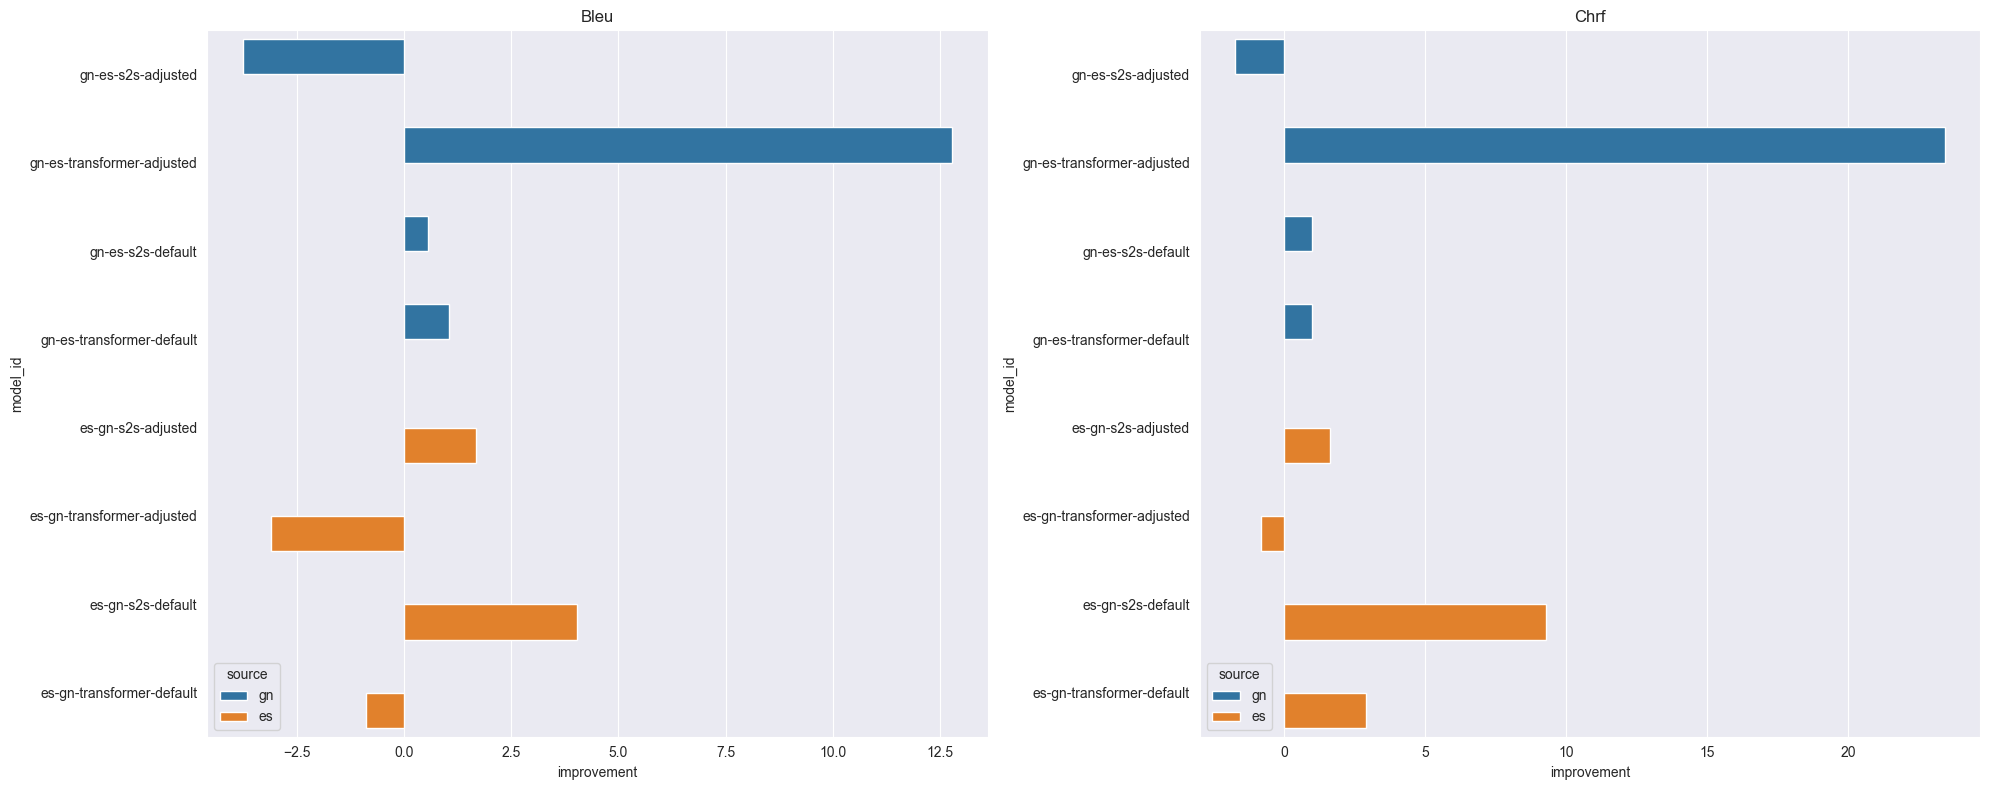

In [170]:
fig, ax = plt.subplots(figsize=(20, 8), ncols=2)
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_bleu-libro_td'], ax=ax[0]);
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_chrf-libro_td'], ax=ax[1]);

ax[0].set_title('Bleu')
ax[1].set_title('Chrf')
plt.tight_layout()

##### **2.1.2.7. seminario**

In [171]:
subcorpus = 'seminario'

In [172]:
current_df = extract_metric_from_subset(light_weight_df, subcorpus, score_types)
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      gn     es       google                      default                NaN   
0      gn     es       google                      default                NaN   
21     gn     es          s2s                     adjusted             ancora   
23     gn     es          s2s                     adjusted             merged   
28     gn     es          s2s                     adjusted     not_pretrained   
22     gn     es          s2s                     adjusted              bible   
20     gn     es          s2s                     adjusted            grammar   
3      gn     es  transformer                     adjusted             merged   
1      gn     es  transformer                     adjusted             ancora   
0      gn     es  transformer                     adjusted            grammar   
2      gn     es  transformer                     adjusted              bible   
25     gn     es          s2s                      default             ancora   
27     gn     es          s2s                      default             merged   
26     gn     es          s2s                      default              bible   
24     gn     es          s2s                      default            grammar   
7      gn     es  transformer                      default             merged   
4      gn     es  transformer                      default            grammar   
5      gn     es  transformer                      default             ancora   
9      gn     es  transformer                      default     not_pretrained   
8      gn     es  transformer                     adjusted     not_pretrained   
29     gn     es          s2s                      default     not_pretrained   
6      gn     es  transformer                      default              bible   
1      es     gn       google                      default                NaN   
1      es     gn       google                      default                NaN   
31     es     gn          s2s                     adjusted             ancora   
33     es     gn          s2s                     adjusted             merged   
32     es     gn          s2s                     adjusted              bible   
38     es     gn          s2s                     adjusted     not_pretrained   
30     es     gn          s2s                     adjusted            grammar   
13     es     gn  transformer                     adjusted             merged   
11     es     gn  transformer                     adjusted             ancora   
10     es     gn  transformer                     adjusted            grammar   
18     es     gn  transformer                     adjusted     not_pretrained   
12     es     gn  transformer                     adjusted              bible   
37     es     gn          s2s                      default             merged   
35     es     gn          s2s                      default             ancora   
34     es     gn          s2s                      default            grammar   
17     es     gn  transformer                      default             merged   
14     es     gn  transformer                      default            grammar   
16     es     gn  transformer                      default              bible   
19     es     gn  transformer                      default     not_pretrained   
15     es     gn  transformer                      default             ancora   
39     es     gn          s2s                      default     not_pretrained   
36     es     gn          s2s                      default              bible   

     pretraining_option  sacrebleu_corpus_bleu  \
0   without_pretraining               26.96010   
0   without_pretraining               26.96010   
21          pretraining               26.83030   
23          pretraining               26.20430   
28  without_pretraining               25.53190   
22          pretraining               25.97270   
20     

In [173]:
get_best_subset_rows(current_df, subcorpus)

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      es     gn       google                      default                NaN   
1      es     gn       google                      default                NaN   
2      es     gn          s2s                     adjusted             ancora   
3      es     gn          s2s                     adjusted     not_pretrained   
4      es     gn          s2s                     adjusted              bible   
5      es     gn          s2s                     adjusted             merged   
22     gn     es       google                      default                NaN   
23     gn     es       google                      default                NaN   
24     gn     es          s2s                     adjusted             ancora   
25     gn     es          s2s                     adjusted             merged   
26     gn     es          s2s                     adjusted     not_pretrained   
27     gn     es  transformer                     adjusted             merged   

     pretraining_option  sacrebleu_corpus_bleu-seminario  \
0   without_pretraining                         8.995765   
1   without_pretraining                         8.995765   
2           pretraining                         8.764977   
3   without_pretraining                         7.678332   
4           pretraining                         7.743413   
5           pretraining                         7.780477   
22  without_pretraining                        13.157852   
23  without_pretraining                        13.157852   
24          pretraining                        10.097703   
25          pretraining                         9.954642   
26  without_pretraining                         9.610910   
27          pretraining                         7.394441   

    sacrebleu_corpus_chrf-seminario  sacrebleu_corpus_ter-seminario  
0                         35.938755                       95.885429  
1                         35.938755                       95.885429  
2                         29.708937                       86.451466  
3                         29.088297                       84.314617  
4                         28.948073                       84.428279  
5                         28.881521                       84.132757  
22                        36.732649                       80.676108  
23                        36.732649                       80.676108  
24                        30.640810                       82.259784  
25                        30.148249                       81.269986  
26                        29.411621                       85.670778  
27                        29.294746                       82.016141

##### **2.1.2.8. spl**

In [174]:
subcorpus = 'spl'

In [175]:
current_df = extract_metric_from_subset(light_weight_df, subcorpus, score_types)
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
22     gn     es          s2s                     adjusted              bible   
28     gn     es          s2s                     adjusted     not_pretrained   
20     gn     es          s2s                     adjusted            grammar   
21     gn     es          s2s                     adjusted             ancora   
23     gn     es          s2s                     adjusted             merged   
3      gn     es  transformer                     adjusted             merged   
1      gn     es  transformer                     adjusted             ancora   
0      gn     es       google                      default                NaN   
0      gn     es       google                      default                NaN   
0      gn     es  transformer                     adjusted            grammar   
2      gn     es  transformer                     adjusted              bible   
25     gn     es          s2s                      default             ancora   
27     gn     es          s2s                      default             merged   
26     gn     es          s2s                      default              bible   
24     gn     es          s2s                      default            grammar   
4      gn     es  transformer                      default            grammar   
5      gn     es  transformer                      default             ancora   
7      gn     es  transformer                      default             merged   
9      gn     es  transformer                      default     not_pretrained   
6      gn     es  transformer                      default              bible   
8      gn     es  transformer                     adjusted     not_pretrained   
29     gn     es          s2s                      default     not_pretrained   
38     es     gn          s2s                     adjusted     not_pretrained   
33     es     gn          s2s                     adjusted             merged   
32     es     gn          s2s                     adjusted              bible   
31     es     gn          s2s                     adjusted             ancora   
30     es     gn          s2s                     adjusted            grammar   
18     es     gn  transformer                     adjusted     not_pretrained   
13     es     gn  transformer                     adjusted             merged   
11     es     gn  transformer                     adjusted             ancora   
10     es     gn  transformer                     adjusted            grammar   
37     es     gn          s2s                      default             merged   
12     es     gn  transformer                     adjusted              bible   
1      es     gn       google                      default                NaN   
1      es     gn       google                      default                NaN   
35     es     gn          s2s                      default             ancora   
34     es     gn          s2s                      default            grammar   
15     es     gn  transformer                      default             ancora   
17     es     gn  transformer                      default             merged   
14     es     gn  transformer                      default            grammar   
16     es     gn  transformer                      default              bible   
19     es     gn  transformer                      default     not_pretrained   
39     es     gn          s2s                      default     not_pretrained   
36     es     gn          s2s                      default              bible   

     pretraining_option  sacrebleu_corpus_bleu  sacrebleu_corpus_bleu-spl  \
22          pretraining               25.97270                  33.975979   
28  without_pretraining               25.53190                  33.164748   
20          pretraining               25.63350                  32.199632   
21          pretraining               26.83030   

In [182]:
get_best_subset_rows(current_df, subcorpus, n=10)

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      es     gn          s2s                     adjusted     not_pretrained   
1      es     gn          s2s                     adjusted             merged   
2      es     gn          s2s                     adjusted              bible   
3      es     gn          s2s                     adjusted             ancora   
4      es     gn          s2s                     adjusted            grammar   
5      es     gn  transformer                     adjusted     not_pretrained   
6      es     gn  transformer                     adjusted             merged   
7      es     gn  transformer                     adjusted             ancora   
8      es     gn  transformer                     adjusted            grammar   
9      es     gn       google                      default                NaN   
22     gn     es          s2s                     adjusted              bible   
23     gn     es          s2s                     adjusted     not_pretrained   
24     gn     es          s2s                     adjusted            grammar   
25     gn     es          s2s                     adjusted             merged   
26     gn     es          s2s                     adjusted             ancora   
27     gn     es  transformer                     adjusted             merged   
28     gn     es  transformer                     adjusted             ancora   
29     gn     es       google                      default                NaN   
30     gn     es       google                      default                NaN   
31     gn     es  transformer                     adjusted            grammar   

     pretraining_option  sacrebleu_corpus_bleu-spl  sacrebleu_corpus_chrf-spl  \
0   without_pretraining                  30.010372                  49.485748   
1           pretraining                  29.575919                  48.497866   
2           pretraining                  29.282374                  48.400873   
3           pretraining                  28.382400                  46.991327   
4           pretraining                  26.782394                  45.715296   
5   without_pretraining                  22.510554                  43.658797   
6           pretraining                  21.479101                  42.472485   
7           pretraining                  20.897296                  42.325749   
8           pretraining                  18.884717                  40.556968   
9   without_pretraining                  16.739908                  39.659287   
22          pretraining                  33.975979                  50.895289   
23  without_pretraining                  33.164748                  50.133414   
24          pretraining                  32.199632                  48.977726   
25          pretraining                  30.588465                  48.612452   
26          pretraining                  31.211923                  48.576903   
27          pretraining                  25.404005                  45.646551   
28          pretraining                  23.982601                  44.715085   
29  without_pretraining                  23.581001                  44.494720   
30  without_pretraining                  23.581001                  44.494720   
31          pretraining                  22.422071                  43.016225   

    sacrebleu_corpus_ter-spl  
0                  68.385696  
1                  67.741060  
2                  70.502816  
3                  72.111013  
4                  73.753138  
5                  72.959218  
6                  73.488498  
7                  74.913483  
8                  75.734546  
9                  88.226912  
22                 62.126770  
23                 63.719526  
24                 63.687021  
25                 64.629673  
26                 63.413049  
27                 66.440678  
28                 69.305781  
29                 69.338287  
30        

### **2.2 By Special Cases**

In [62]:
def plot_values_by_index(title, 
                         values, 
                         color=None, 
                         ax=None, 
                         source_indices:list=None, 
                         source_names:list=None):
    import random; random.seed(0)

    sns.set_style('darkgrid')
    x = list(range(len(values)))
    y = values

    if ax is None:
        plt.figure(figsize=(20, 6))
        ax = sns.lineplot(x=x, y=y, color=color)
    else:
        ax.plot(x, y, color=color)

    if source_indices is not None and source_names is not None:
        for i, source_index in enumerate(source_indices):
            ax.axvline(source_index, color='black')
            ax.text(source_index - 115,
                    -20,
                    source_names[i],
                    verticalalignment='top',
                    rotation=90,
                    fontdict={'size': 12})
            
    # Plot moving average
    moving_average = []
    confidence_interval = []
    moving_average_window = 200

    for i in range(len(values)):
        source_base_idx = max([0] + 
                              [idx for idx in source_indices if idx <= i]) # Consider being outside of source index
        start_idx = max(0, i-moving_average_window, source_base_idx)
        end_idx = i
        divisor = end_idx - start_idx + 1
        current_values = values[start_idx:i+1]
        current_mean = sum(current_values) / divisor
        current_std = statistics.stdev(current_values) if len (current_values) > 1 else 0

        moving_average.append(current_mean)
        confidence_interval.append(current_std)

    
    ax.plot(x, moving_average, color='black', alpha=0.8)
    ax.fill_between(x, [mean - std for mean, std in zip(moving_average, 
                                                        confidence_interval)], 
                        [mean + std for mean, std in zip(moving_average, 
                                                         confidence_interval)], 
                        alpha=0.2, 
                        color='black', 
                        zorder=2)
    
    # Remove xtick = 4000
    ax.set_xticks([0, 1000, 2000, 3000, 5000])

    ax.set_title(title)
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    plt.tight_layout()

    if ax is None:
        plt.show()

In [63]:
def plot_individual_metrics(df, 
                            source_indices:list=None, 
                            source_names:list=None,
                            save_path:str=None):
    _, ax = plt.subplots(figsize=(20, len(df)*4), nrows=len(df), ncols=2)

    for i, (_, row) in enumerate(df.iterrows()):
        test_filelines = test_gn_filelines if row['target'] == 'gn' else test_es_filelines
        filelines = row['filelines']
        metric_df = create_bleu_scores_df(test_filelines, filelines, bleu_score_types=['sacrebleu_sentence_chrf', 
                                                                                       'sacrebleu_sentence_bleu'])
        sacrebleu_scores = metric_df[metric_df['metric'] == 'sacrebleu_sentence_bleu']['score']
        chrf_scores = metric_df[metric_df['metric'] == 'sacrebleu_sentence_chrf']['score']

        options_mapping = {
            'pretraining': 'Preentrenado',
            'without_pretraining': 'Sin preentrenar',
            'default': 'Default',
            'adjusted': 'Ajustado',
            'merged': 'Todos'
        }

        map_option = lambda option: options_mapping.get(option, option)

        create_title = lambda row_, metric: (
            f' Modelo {row_["architecture"]}' +
            (f' | Dirección ({row_["source"]},{row_["target"]})' if row_["source"] and row_["target"] else '') +
            (f' | {map_option(row_["pretraining_option"])}' if row_["pretraining_option"] != 'without_pretraining' and pd.notna(row_["pretraining_option"]) else '') +
            (f' | Corpus {map_option(row_["pretraining_corpus"])}' if row_["pretraining_corpus"] != 'not_pretrained' and pd.notna(row_["pretraining_corpus"]) else '') +
            (f' | {map_option(row_["hyperparameter_tuning_option"])}' if not pd.isna(row_["hyperparameter_tuning_option"]) and row_['architecture'] != 'google' else '') +
            (f'{" | BLEU" if metric == "sacrebleu_corpus_bleu" else " | chrF"}: {row_[metric]}' if not pd.isna(row_[metric]) else '')
        )
        
        bleu_title = create_title(row, 'sacrebleu_corpus_bleu')
        chrf_title = create_title(row, 'sacrebleu_corpus_chrf')

        plot_values_by_index(bleu_title, 
                            sacrebleu_scores, 
                            color='brown',
                            ax=ax[i, 0],
                            source_indices=source_indices,
                            source_names=source_names)
        plot_values_by_index(chrf_title, 
                            chrf_scores, 
                            ax=ax[i, 1],
                            source_indices=source_indices,
                            source_names=source_names)
        
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

**Grammar enhancement**

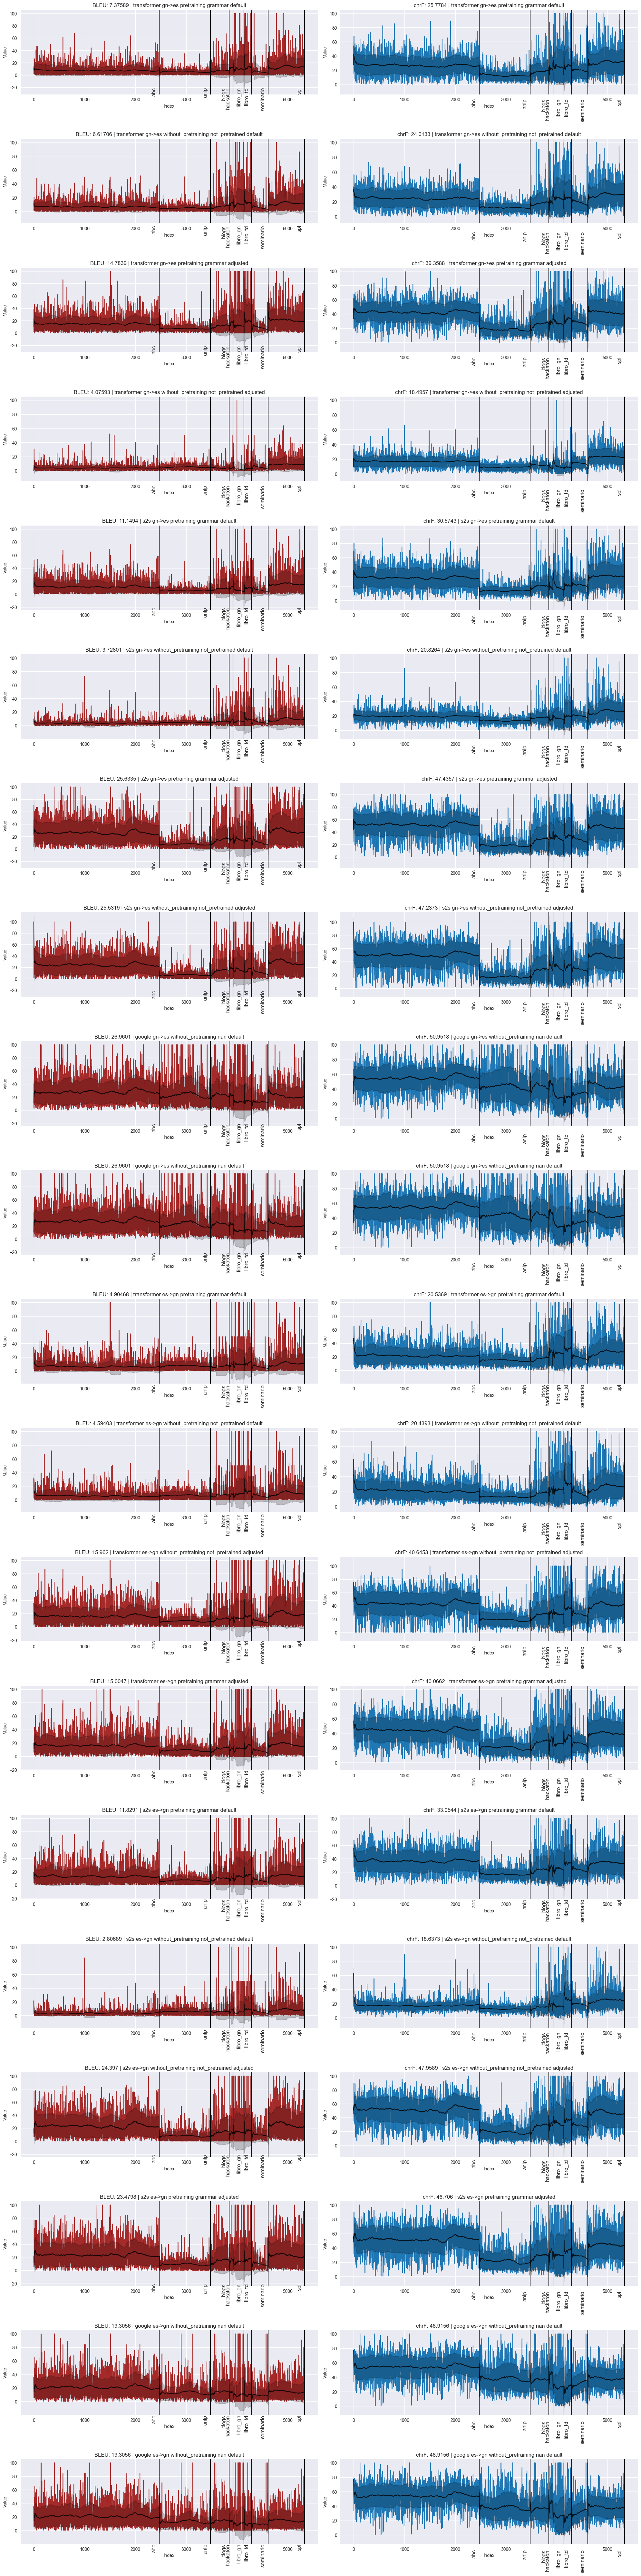

In [179]:
grammar_comparison_df = df[(df['pretraining_corpus']=='grammar') | (df['pretraining_option']=='without_pretraining')]
grammar_comparison_df = grammar_comparison_df.sort_values(by=['source', 
                                                              'architecture', 
                                                              'hyperparameter_tuning_option', 
                                                              'sacrebleu_corpus_bleu'], 
                                                          ascending=False)
plot_individual_metrics(grammar_comparison_df, 
                        source_indices=last_source_indices, 
                        source_names=source_names)

**Google**

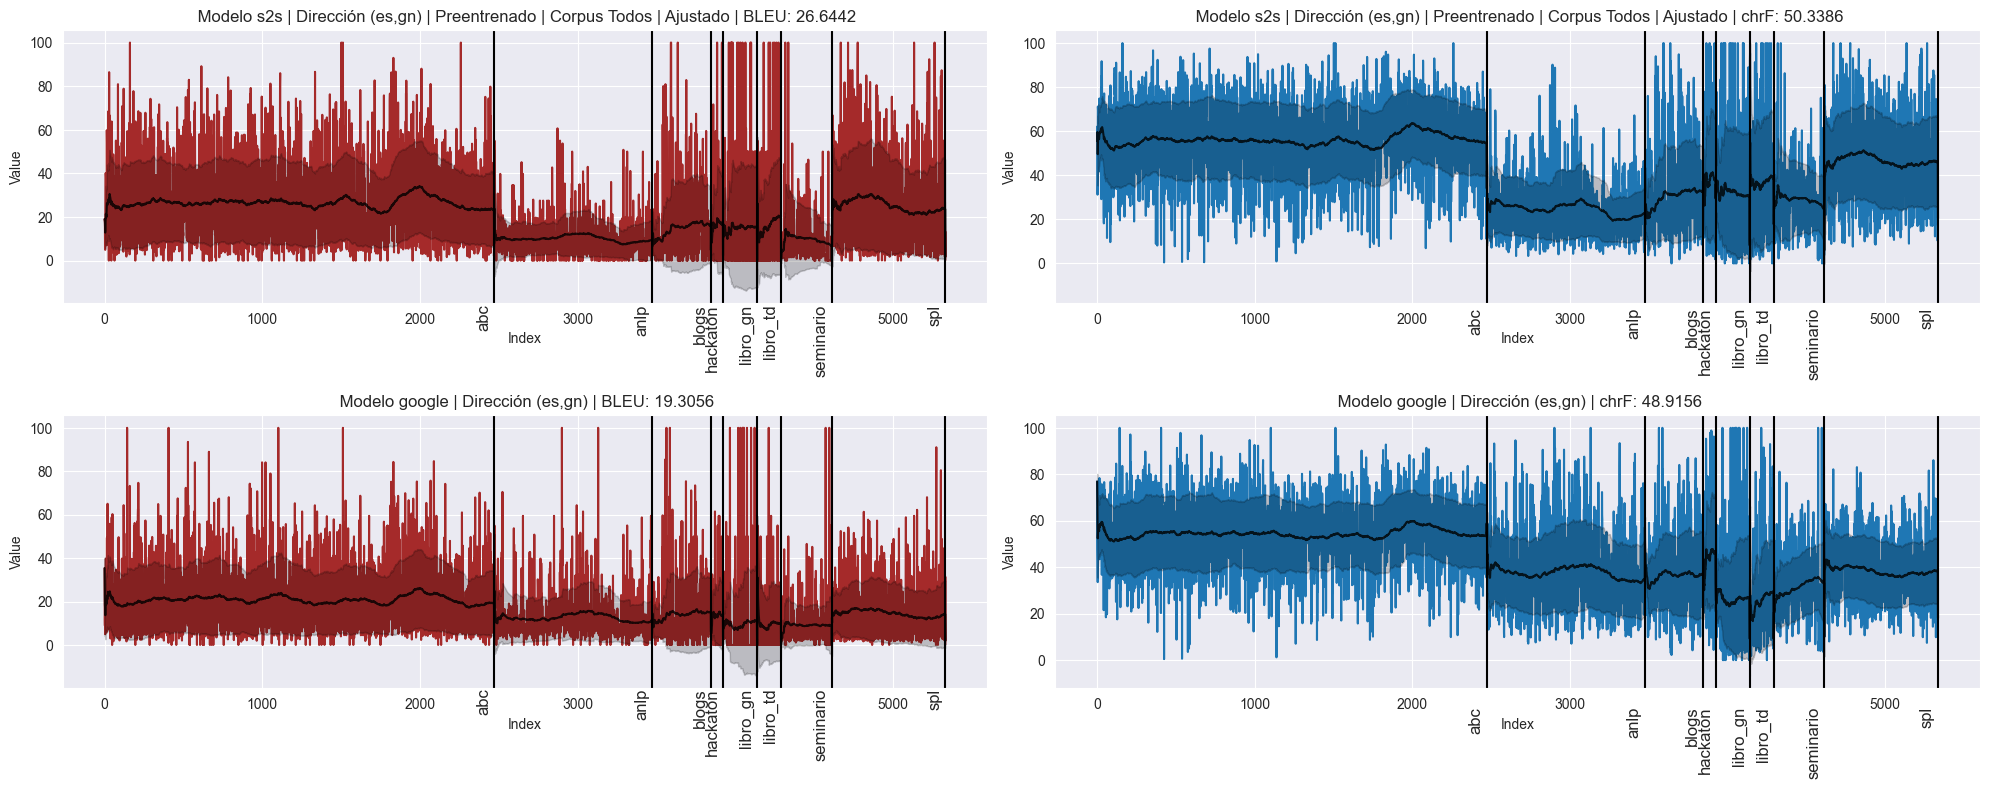

In [64]:
best_dfs = (df[((df['sacrebleu_corpus_chrf'] > 50) | (df['architecture']=='google')) & (df['source']=='es')]
           .drop_duplicates(subset=['source', 'target', 'architecture', 'hyperparameter_tuning_option', 'pretraining_option', 'pretraining_corpus']))
plot_individual_metrics(best_dfs,
                        source_indices=last_source_indices,
                        source_names=source_names,
                        save_path=os.path.join(RESULTS_DIR,
                                               'final_document',
                                               'level4_google_subsets.png'))